# House Prices - EDA + Pipelines + Stacking

## Lucas Pierezan

**Feb 2019**



In [1]:
import numpy as np
import pandas as pd
import os
print('input files:\n', os.listdir("../input"))
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from itertools import product
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.base import BaseEstimator, RegressorMixin

from scipy import stats
import datetime

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,8)

import sklearn as sk
print('sklearn:',sk.__version__)
print('seaborn:',sns.__version__)
print('xgboost', xgb.__version__)

pd.options.display.max_rows = 999

input files:
 ['sample_submission.csv', 'test.csv', 'data_description.txt', 'train.csv']
sklearn: 0.20.2
seaborn: 0.9.0
xgboost 0.81


--------------

### Some utility functions:

In [2]:
def grid_plot(df, y, cols = None, hue = None, plot_func = sns.boxplot, n_col = 3, figsize = (25,30)):
    if cols is None:
        cols = df.columns
        
    shape = (int(np.ceil(len(cols)/n_col)), n_col)
    fig, axs = plt.subplots(shape[0],shape[1], figsize = figsize)
    
    for i,c in enumerate(cols):
        args = {'x' : c, 'y' : y}
        if hue is not None:
            args['hue'] = hue
            args['dodge'] = True

        plot_func(**args, data = df, ax = axs[i//n_col, i%n_col] if shape[0] > 1 else axs[i%n_col])
        
def df_info(df):
    features_info = pd.DataFrame(data = {'dtype' : df.dtypes, 
                             'na_count' : df.isnull().sum(axis = 0),
                             '0_count' : (df == 0).sum(axis = 0),
                             'unique_count': df.nunique(dropna=False)
                            })
    return features_info


# The dataset

In [3]:
df_raw = pd.read_csv('..//input//train.csv')
df_test = pd.read_csv('../input/test.csv')
target_col = 'SalePrice'
df = df_raw.copy().drop('Id', axis = 1)
features_info = df_info(df)
display(features_info)
display(df.head())

dtype  na_count  0_count  unique_count
MSSubClass       int64         0        0            15
MSZoning        object         0        0             5
LotFrontage    float64       259        0           111
LotArea          int64         0        0          1073
Street          object         0        0             2
Alley           object      1369        0             3
LotShape        object         0        0             4
LandContour     object         0        0             4
Utilities       object         0        0             2
LotConfig       object         0        0             5
LandSlope       object         0        0             3
Neighborhood    object         0        0            25
Condition1      object         0        0             9
Condition2      object         0        0             8
BldgType        object         0        0             5
HouseStyle      object         0        0             8
OverallQual      int64         0        0            10
OverallCond      int64         0        0             9
YearBuilt        int64         0        0           112
YearRemodAdd     int64         0        0            61
RoofStyle       object         0        0             6
RoofMatl        object         0        0             8
Exterior1st     object         0        0            15
Exterior2nd     object         0        0            16
MasVnrType      object         8        0             5
MasVnrArea     float64         8      861           328
ExterQual       object         0        0             4
ExterCond       object         0        0             5
Foundation      object         0        0             6
BsmtQual        object        37        0             5
BsmtCond        object        37        0             5
BsmtExposure    object        38        0             5
BsmtFinType1    object        37        0             7
BsmtFinSF1       int64         0      467           637
BsmtFinType2    object        38        0             7
BsmtFinSF2       int64         0     1293           144
BsmtUnfSF        int64         0      118           780
TotalBsmtSF      int64         0       37           721
Heating         object         0        0             6
HeatingQC       object         0        0             5
CentralAir      object         0        0             2
Electrical      object         1        0             6
1stFlrSF         int64         0        0           753
2ndFlrSF         int64         0      829           417
LowQualFinSF     int64         0     1434            24
GrLivArea        int64         0        0           861
BsmtFullBath     int64         0      856             4
BsmtHalfBath     int64         0     1378             3
FullBath         int64         0        9             4
HalfBath         int64         0      913             3
BedroomAbvGr     int64         0        6             8
KitchenAbvGr     int64         0        1             4
KitchenQual     object         0        0             4
TotRmsAbvGrd     int64         0        0            12
Functional      object         0        0             7
Fireplaces       int64         0      690             4
FireplaceQu     object       690        0             6
GarageType      object        81        0             7
GarageYrBlt    float64        81        0            98
GarageFinish    object        81        0             4
GarageCars       int64         0       81             5
GarageArea       int64         0       81           441
GarageQual      object        81        0             6
GarageCond      object        81        0             6
PavedDrive      object         0        0             3
WoodDeckSF       int64         0      761           274
OpenPorchSF      int64         0      656           202
EnclosedPorch    int64         0     1252           120
3SsnPorch        int64         0     1436            20
ScreenPorch      int64         0     1344            76
PoolArea         int64         0     1453

MSSubClass MSZoning  LotFrontage    ...     SaleType SaleCondition SalePrice
0          60       RL         65.0    ...           WD        Normal    208500
1          20       RL         80.0    ...           WD        Normal    181500
2          60       RL         68.0    ...           WD        Normal    223500
3          70       RL         60.0    ...           WD       Abnorml    140000
4          60       RL         84.0    ...           WD        Normal    250000

[5 rows x 80 columns]

# How about the target?

Let's change to log scale because the score is in this scale.  
It also makes the target closer to a normal distribution.

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


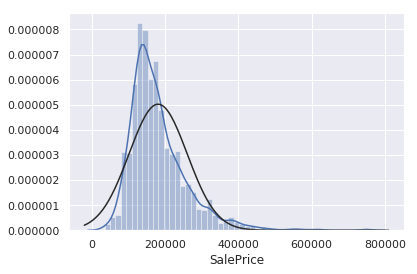

In [4]:
display(df[target_col].describe())
sns.distplot(df[target_col], fit = stats.norm)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


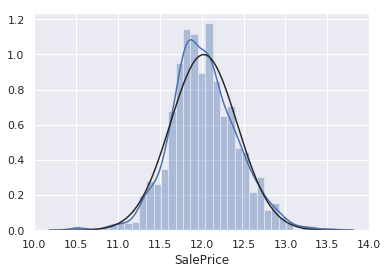

In [5]:
df[target_col] = np.log(df_raw[target_col])
y = df[target_col]
sns.distplot(y, fit = stats.norm)

In [6]:
df.drop(target_col, axis = 1, inplace=True)

### Baseline MSE

In [7]:
base_mse = mean_squared_error(y, y.mean() + np.zeros_like(y))
print('MSE:', base_mse)
print('RMSE:', base_mse**0.5)
#mean_squared_error(y, y.median() + np.zeros_like(y))

MSE: 0.15945250615661033
RMSE: 0.39931504624370256


# **EDA**

## Changing columns types

- **MSSubClass** is encoded with integers but it is categorical.  
- **OverallQual, OverallCond** : ordinal but can be analysed as categorical  (str)  
- **YearBuilt , YearRemodAdd, GarageYrBlt, YrSold** : lets keep numerical for eda (but can be used further in bucketized or categorical form).  
- **MoSold** : lets keep numerical for eda.


In [8]:
year_cols = ['YearBuilt' , 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
month_cols = ['MoSold']
overall_rank_cols = ['OverallQual', 'OverallCond']

for col in overall_rank_cols + ['MSSubClass']:
    df[col] = df[col].astype(str)

In [9]:
df_cat = df.select_dtypes(exclude=[np.number])
df_num = df.select_dtypes(include=[np.number])
print('n_cat:', df_cat.shape[1])
print('n_num:', df_num.shape[1])

n_cat: 46
n_num: 33


## Categoricals

### Where are the NA's?

In [10]:
def na_info(df):    
    info = df_info(df)
    na = info[info['na_count'] > 0].sort_values('na_count', ascending = False)    
    na_index = na.index
    na['na_percent'] = na['na_count'] / len(df)
    display(na)
    if len(na) > 0:
        plt.figure(figsize = (6,6))
        sns.barplot(x = na['na_percent'] , y = na.index);

dtype  na_count  0_count  unique_count  na_percent
PoolQC        object      1453        0             4    0.995205
MiscFeature   object      1406        0             5    0.963014
Alley         object      1369        0             3    0.937671
Fence         object      1179        0             5    0.807534
FireplaceQu   object       690        0             6    0.472603
GarageType    object        81        0             7    0.055479
GarageFinish  object        81        0             4    0.055479
GarageQual    object        81        0             6    0.055479
GarageCond    object        81        0             6    0.055479
BsmtExposure  object        38        0             5    0.026027
BsmtFinType2  object        38        0             7    0.026027
BsmtQual      object        37        0             5    0.025342
BsmtCond      object        37        0             5    0.025342
BsmtFinType1  object        37        0             7    0.025342
MasVnrType    object         8        0             5    0.005479
Electrical    object         1        0             6    0.000685

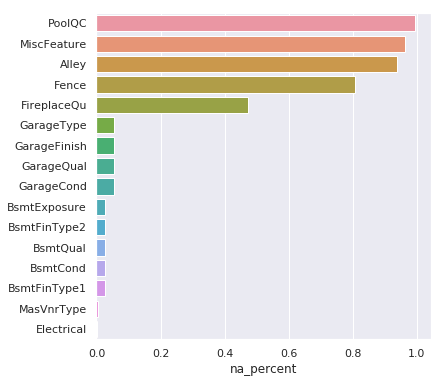

In [11]:
na_info(df_cat)

All categoricals, except for *Electrical* and *MasVnrType*: the absence is encoded with "NA" (data_description.txt)

*MasVnrType* : The absence is encoded with "None".

*Electrical* : It's just one example. Lets put "NA" for EDA.

### Impute NA for EDA

Impute NA for every categorical column so that we can groupby, filter, compare, etc...

In [12]:
na_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtExposure',
       'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1'] + ['Electrical']

df_cat['MasVnrType'] = df_cat['MasVnrType'].fillna('None')
df_cat[na_cols] = df_cat[na_cols].fillna('NA')

na_info(df_cat)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Empty DataFrame
Columns: [dtype, na_count, 0_count, unique_count, na_percent]
Index: []

Let's make a OHE dataframe for some analyses that need only numerical.

In [13]:
df_ohe = pd.get_dummies(df_cat)

### Mutual Information Score

Let's see some informative categoricals according to mutual information.

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


mi_good_cats: ['ExterQual_TA', 'ExterQual_Gd', 'KitchenQual_TA', 'BsmtQual_TA', 'Foundation_PConc', 'KitchenQual_Gd', 'FireplaceQu_NA', 'BsmtQual_Gd', 'OverallQual_5', 'OverallQual_8']


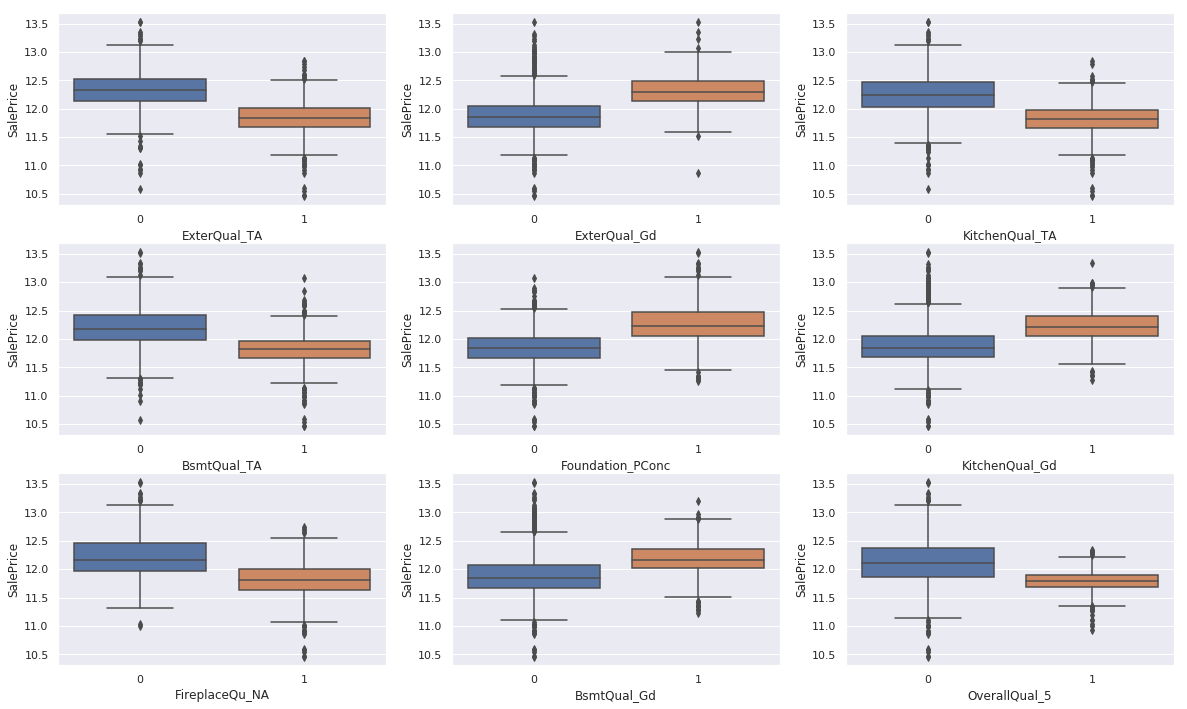

In [14]:
mi_good_cats = list(df_ohe.columns[mutual_info_regression(df_ohe, y).argsort()][-1::-1])
print('mi_good_cats:', mi_good_cats[:10])
grid_plot(df_ohe, y , cols = mi_good_cats[:9], figsize = (20,12))

### Looking closer to categorical values

For every categorical value, let's compute:

- How many examples are assign to that value.
- What is the mean log(SalpePrice) for these examples and the mean for the remaining examples.
- What is the loss when we use these means as predictions.

This gives some ideia of informtive categorical values and could be used as feature selection criteria.


In [15]:
def fv_info(series, value, y, base_loss, loss):
    dic_ret = {}
    if pd.isnull(value):
        mask = series.isnull()
    else:
        mask = (series == value)

    n = mask.sum()
    dic_ret['feature'] = series.name
    dic_ret['value'] = str(value)
    dic_ret['count'] = n
    dic_ret['p'] = dic_ret['count']/len(series)
    dic_ret['y_in_mean'] = y[mask].mean()
    dic_ret['loss_in'] = loss(y[mask], dic_ret['y_in_mean']) if n > 0 else 0
    dic_ret['loss_out'] = loss(y[~mask], y[~mask].mean())
    dic_ret['loss'] = (dic_ret['p']*dic_ret['loss_in']**2 + (1 - dic_ret['p'])*dic_ret['loss_out']**2)**0.5
    dic_ret['delta_loss'] = base_loss - dic_ret['loss']
    
    return dic_ret


def split_info(df_imp, y, cols = 'all', loss = None):
    if loss is None:
        loss = lambda y_true, y_pred : mean_squared_error(y_true, y_pred + np.zeros_like(y_true))**0.5
    
    base_loss = loss(y, y.mean())
    
    if isinstance(cols, str) and cols == 'all':
        cols = list(df_imp.columns)
        
    dfs = []
    for col in cols:
        series = df_imp[col]
        values = list(set(series[~series.isnull()]))
        values += [None] if series.isnull().sum() > 0 else []
        order = ['feature', 'value', 'count', 'p', 'y_in_mean','loss_in', 'loss_out', 'loss', 'delta_loss']
        records = list(map(lambda value: fv_info(series, value, y, base_loss, loss), values))
        df_col = pd.DataFrame(records, columns=order)
        dfs.append(df_col)
        
    return pd.concat(dfs, axis = 0, ignore_index=True).sort_values('delta_loss', ascending = False)

The thresholds used below have been found by experimentation.

In [16]:
ci = split_info(df_cat, y)

print('good delta loss')
mask2 = ci['delta_loss'] > 0.025
display(ci[mask2].head(10))
si_good_cats = set(ci[mask2]['feature'])

print('representative value and low loss')
mask1 = (ci['p'] > 0.04) & (ci['loss_in'] < 0.31)
display(ci[mask1].sort_values('loss_in').head(10))
si_rll_cats = set(ci[mask1]['feature'])

print('low representative + bad loss')
mask3 = (ci['loss_in'] > 0.022) & (ci['p'] <= 0.05)
display(ci[mask3].sort_values('loss_in').head(10))

good delta loss


feature  value  count     ...      loss_out      loss  delta_loss
166     ExterQual     TA    906     ...      0.360694  0.320679    0.078636
229   KitchenQual     TA    735     ...      0.382927  0.336540    0.062775
177    Foundation  PConc    647     ...      0.329816  0.338408    0.060907
242   FireplaceQu     NA    690     ...      0.360685  0.343475    0.055841
167     ExterQual     Gd    488     ...      0.369206  0.343558    0.055758
185      BsmtQual     TA    649     ...      0.387135  0.350827    0.048488
216     HeatingQC     Ex    741     ...      0.337284  0.353159    0.046156
181      BsmtQual     Ex    121     ...      0.354809  0.353729    0.045586
196  BsmtFinType1    GLQ    418     ...      0.357821  0.358435    0.040881
255  GarageFinish    Unf    605     ...      0.398234  0.360130    0.039185

[10 rows x 9 columns]

representative value and low loss


feature    value  count     ...      loss_out      loss  delta_loss
47   Neighborhood  Gilbert     79     ...      0.407527  0.398070    0.001245
65   Neighborhood   Sawyer     74     ...      0.404631  0.396282    0.003033
62   Neighborhood   NWAmes     73     ...      0.406388  0.398566    0.000749
97     HouseStyle     SLvl     65     ...      0.406136  0.399287    0.000028
66   Neighborhood    NAmes    225     ...      0.418959  0.393724    0.005591
98    OverallQual        7    319     ...      0.421486  0.385386    0.013929
99    OverallQual        5    397     ...      0.414765  0.370578    0.028737
16       MSZoning       FV     65     ...      0.402512  0.396414    0.002901
106   OverallQual        6    374     ...      0.441274  0.397924    0.001391
101   OverallQual        8    168     ...      0.374668  0.361031    0.038284

[10 rows x 9 columns]

low representative + bad loss


feature    value      ...           loss    delta_loss
263    GarageCond       Ex      ...       0.399164  1.509392e-04
214       Heating     OthW      ...       0.399178  1.370465e-04
215       Heating     Wall      ...       0.398098  1.216865e-03
189      BsmtCond       Po      ...       0.397734  1.581186e-03
52   Neighborhood  NPkVill      ...       0.399122  1.928860e-04
51   Neighborhood  Blueste      ...       0.399248  6.701362e-05
82     Condition2   Artery      ...       0.398961  3.542090e-04
142   Exterior1st    Stone      ...       0.398994  3.213986e-04
283   MiscFeature     Gar2      ...       0.399315  5.265759e-07
4      MSSubClass       85      ...       0.399029  2.858564e-04

[10 rows x 9 columns]

In [17]:
si_cats = si_good_cats.union(si_rll_cats)
not_in_si = set(df_cat.columns).difference(si_cats)
print('Most informative categoricals (Split Information)\n' , si_cats)

#print('Not in si:', not_in_si)

Most informative categoricals (Split Information)
 {'OverallQual', 'HouseStyle', 'FireplaceQu', 'MasVnrType', 'Exterior1st', 'MSZoning', 'KitchenQual', 'GarageType', 'HeatingQC', 'CentralAir', 'BsmtFinType1', 'Neighborhood', 'Fence', 'Exterior2nd', 'GarageCond', 'ExterQual', 'MSSubClass', 'BsmtQual', 'OverallCond', 'GarageFinish', 'Foundation'}


### Boxplot for all Categoricals

Let's make classical boxplots.

As we can see, some classes have outliers.  
We used the *hue* option in the code below to follow an example across all the boxplots.

In [18]:
#display(y[df_cat['OverallCond'] == '2'])

hue = None

# We can uncomment this to follow a specific point in all the plots

"""idx_select = 523
hue = pd.Series(index = df_cat.index, data = 0)
hue.loc[idx_select] = 1"""

'idx_select = 523\nhue = pd.Series(index = df_cat.index, data = 0)\nhue.loc[idx_select] = 1'

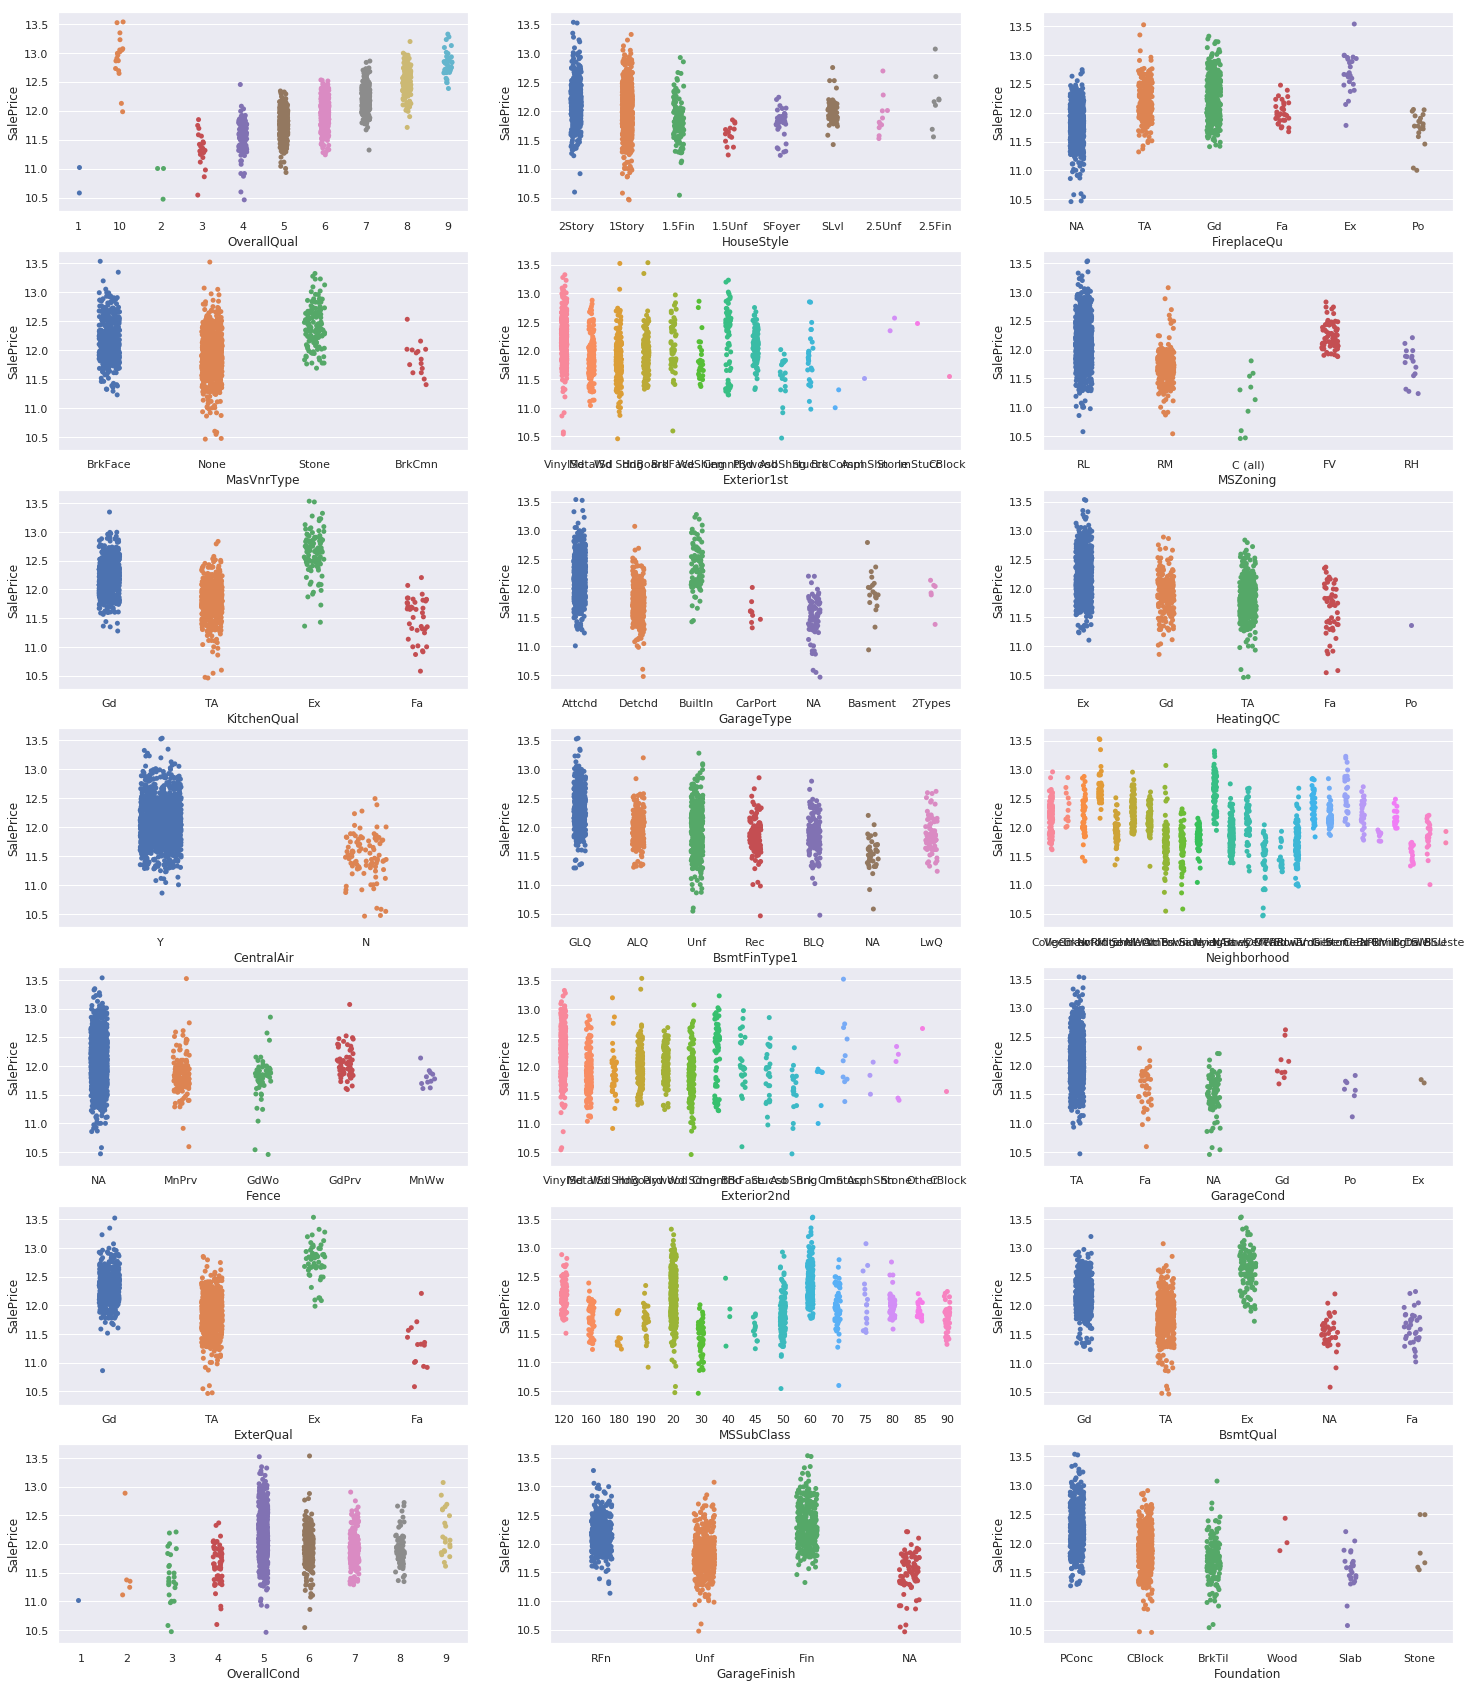

In [19]:
grid_plot(df_cat, y, hue = hue, cols = list(si_cats), plot_func = sns.stripplot)

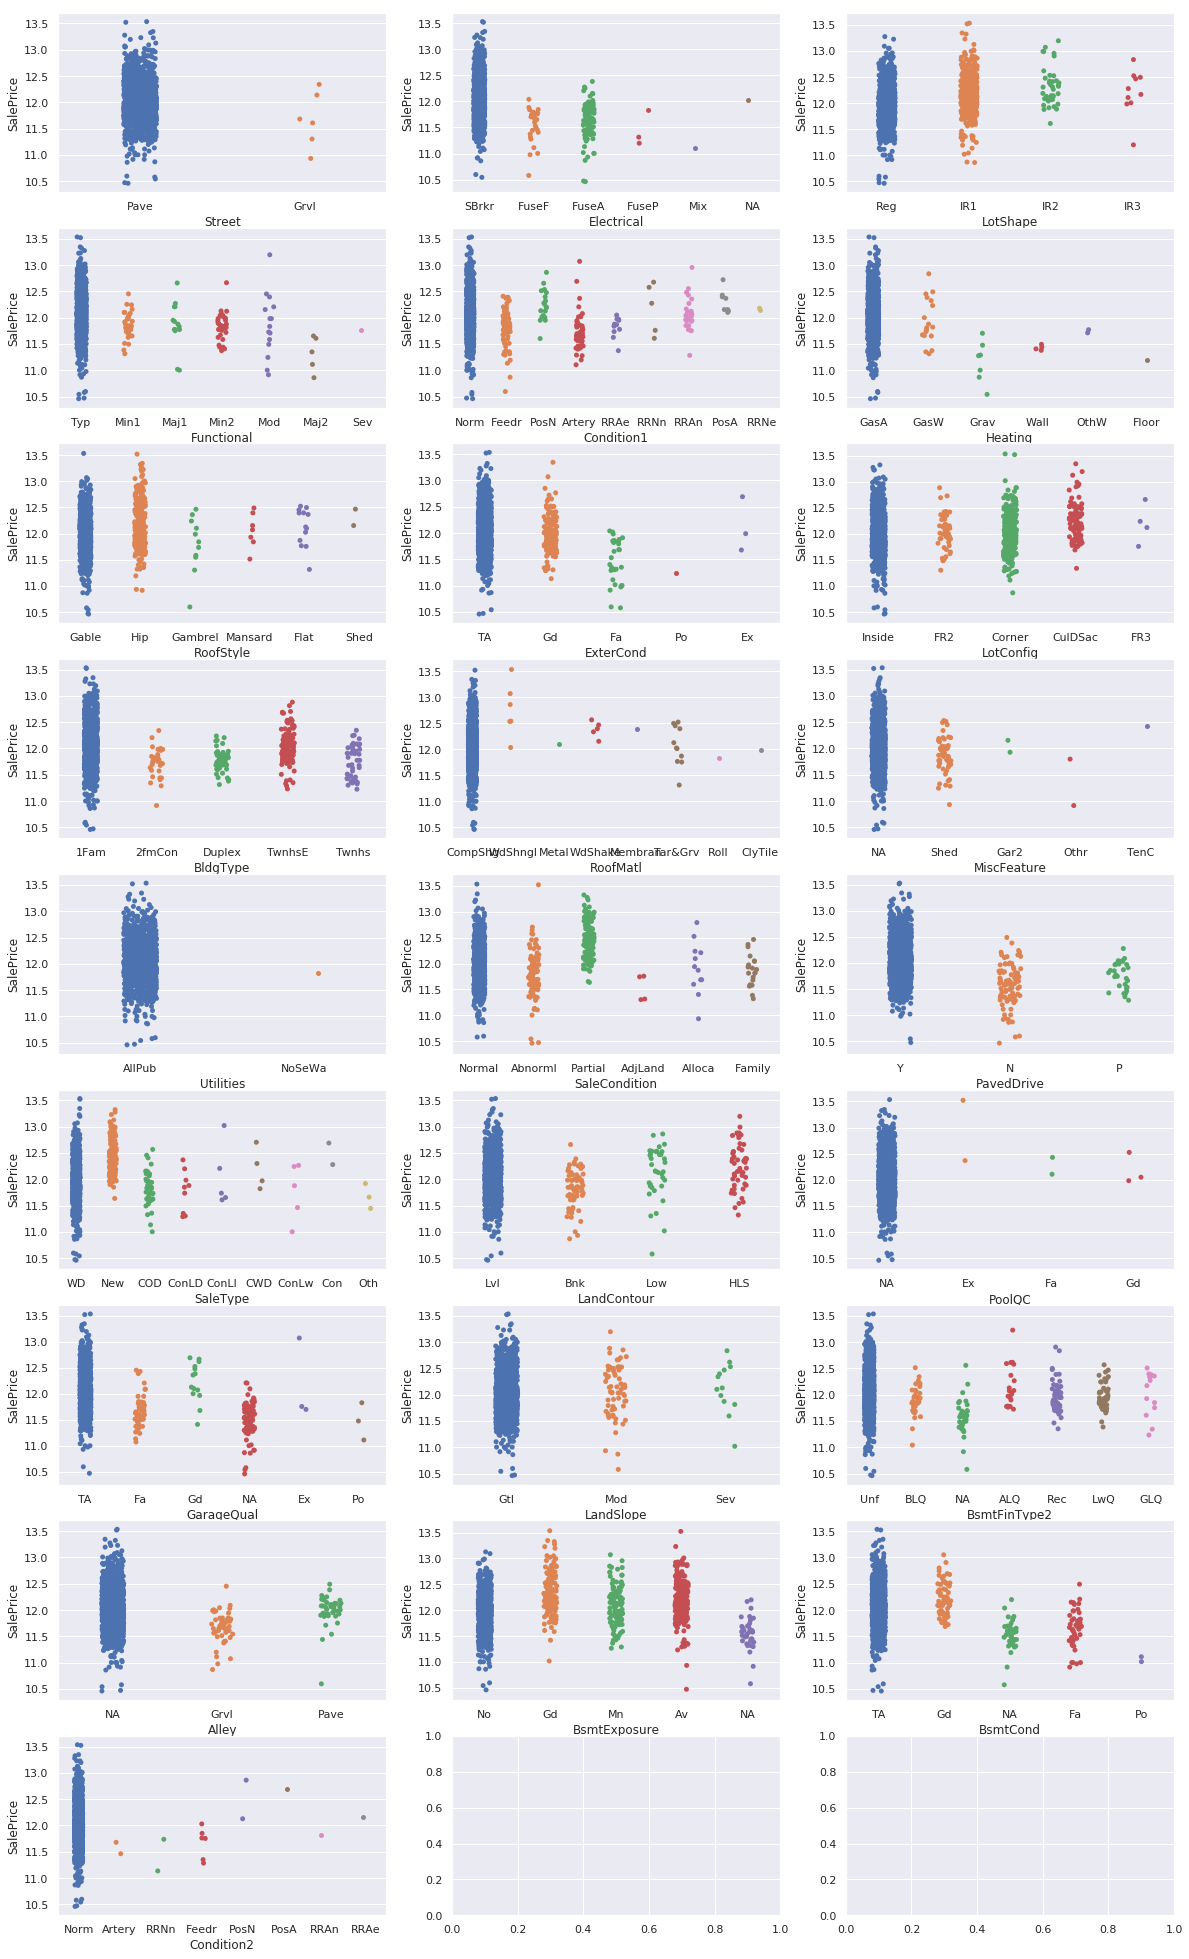

In [20]:
grid_plot(df_cat, y, hue = hue, cols = list(not_in_si), figsize=(20,35), plot_func = sns.stripplot)

There are some categoricals with strong relationship with SalePrice, such as: OverallQual, BsmtQual, KitchenQual,...  

Even so, it's important to notice that some categories are very underrepresented.
For example: HeatingQC-Po, Foundation Wood and Stone, OverallQual 1 and 2, ....  
This suggests that some grouping could be good.

We can view of some SalePrice outliers, with respect a given category. For example in Neighborhood and MSSubClass

### Interactions

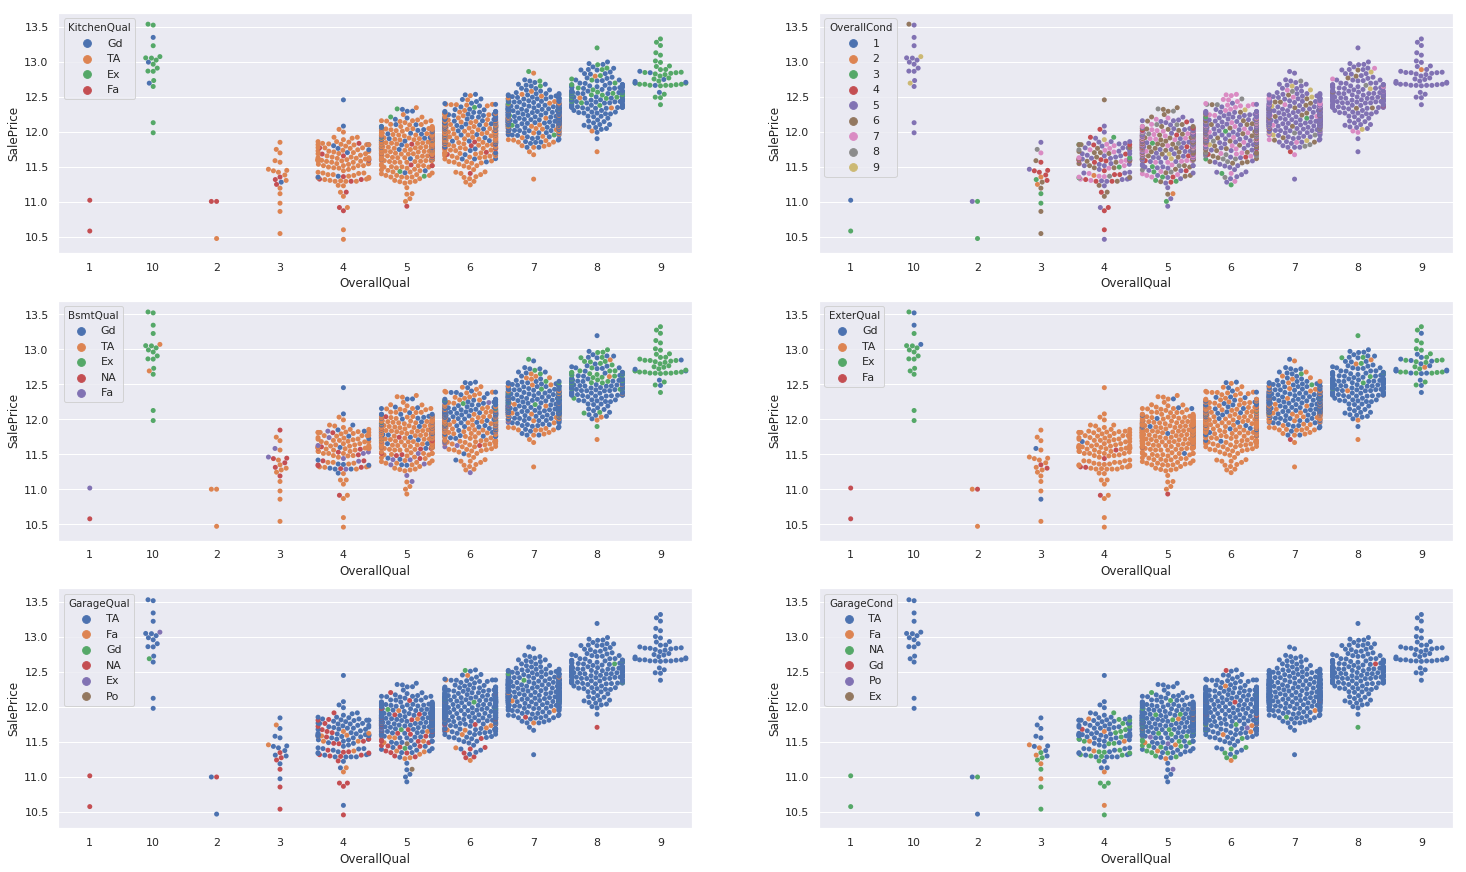

In [21]:
fig, axs = plt.subplots(3, 2, figsize = (25,15))

sns.swarmplot(hue = df_cat['KitchenQual'], y = y, x = df_cat['OverallQual'], ax = axs[0,0])
sns.swarmplot(hue = df_cat['OverallCond'], y = y, x = df_cat['OverallQual'], ax = axs[0,1])
sns.swarmplot(hue = df_cat['BsmtQual'], y = y, x = df_cat['OverallQual'], ax = axs[1,0])
sns.swarmplot(hue = df_cat['ExterQual'], y = y, x = df_cat['OverallQual'], ax = axs[1,1])
sns.swarmplot(hue = df_cat['GarageQual'], y = y, x = df_cat['OverallQual'], ax = axs[2,0])
sns.swarmplot(hue = df_cat['GarageCond'], y = y, x = df_cat['OverallQual'], ax = axs[2,1])

## Numerical data

In [22]:
df_num.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T

count          mean    ...          95%       max
LotFrontage    1201.0     70.049958    ...       107.00     313.0
LotArea        1460.0  10516.828082    ...     17401.15  215245.0
YearBuilt      1460.0   1971.267808    ...      2007.00    2010.0
YearRemodAdd   1460.0   1984.865753    ...      2007.00    2010.0
MasVnrArea     1452.0    103.685262    ...       456.00    1600.0
BsmtFinSF1     1460.0    443.639726    ...      1274.00    5644.0
BsmtFinSF2     1460.0     46.549315    ...       396.20    1474.0
BsmtUnfSF      1460.0    567.240411    ...      1468.00    2336.0
TotalBsmtSF    1460.0   1057.429452    ...      1753.00    6110.0
1stFlrSF       1460.0   1162.626712    ...      1831.25    4692.0
2ndFlrSF       1460.0    346.992466    ...      1141.05    2065.0
LowQualFinSF   1460.0      5.844521    ...         0.00     572.0
GrLivArea      1460.0   1515.463699    ...      2466.10    5642.0
BsmtFullBath   1460.0      0.425342    ...         1.00       3.0
BsmtHalfBath   1460.0      0.057534    ...         1.00       2.0
FullBath       1460.0      1.565068    ...         2.00       3.0
HalfBath       1460.0      0.382877    ...         1.00       2.0
BedroomAbvGr   1460.0      2.866438    ...         4.00       8.0
KitchenAbvGr   1460.0      1.046575    ...         1.00       3.0
TotRmsAbvGrd   1460.0      6.517808    ...        10.00      14.0
Fireplaces     1460.0      0.613014    ...         2.00       3.0
GarageYrBlt    1379.0   1978.506164    ...      2007.00    2010.0
GarageCars     1460.0      1.767123    ...         3.00       4.0
GarageArea     1460.0    472.980137    ...       850.10    1418.0
WoodDeckSF     1460.0     94.244521    ...       335.00     857.0
OpenPorchSF    1460.0     46.660274    ...       175.05     547.0
EnclosedPorch  1460.0     21.954110    ...       180.15     552.0
3SsnPorch      1460.0      3.409589    ...         0.00     508.0
ScreenPorch    1460.0     15.060959    ...       160.00     480.0
PoolArea       1460.0      2.758904    ...         0.00     738.0
MiscVal        1460.0     43.489041    ...         0.00   15500.0
MoSold         1460.0      6.321918    ...        11.00      12.0
YrSold         1460.0   2007.815753    ...      2010.00    2010.0

[33 rows x 10 columns]

### Where are the NA's?

dtype  na_count  0_count  unique_count  na_percent
LotFrontage  float64       259        0           111    0.177397
GarageYrBlt  float64        81        0            98    0.055479
MasVnrArea   float64         8      861           328    0.005479

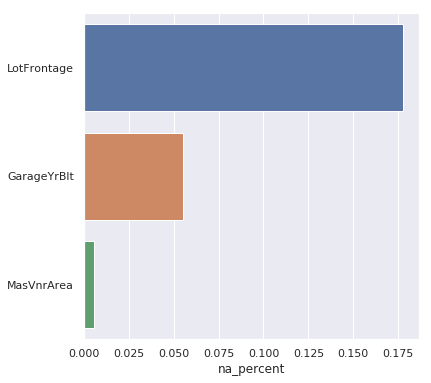

In [23]:
na_info(df_num)

In [24]:
# No Masonty => MasVnrArea = 0
df_num['MasVnrArea'] = df_num['MasVnrArea'].fillna(0)

# No garage => GarageYrBlt = 0
df_num['GarageYrBlt'] = df_num['GarageYrBlt'].fillna(0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


The examples with NA in LotFrontage are spread over all the categoricals. I've not found a clear pattern that explains it.  
We can impute with the Neighborhood mean.

In [25]:
# Categorical boxplots only for examples with LotFrontage equals NA

#mask = df_num['LotFrontage'].isnull()
#grid_plot(df_cat[mask], y[mask], plot_func = sns.stripplot, figsize=(20,60))

In [26]:
# Scatterplots looking for LotFrontage and numerical feature relationship

#mask = ~df_num['LotFrontage'].isnull()
#grid_plot(df_num[mask], df_num['LotFrontage'][mask], plot_func=sns.scatterplot, figsize=(20,40))

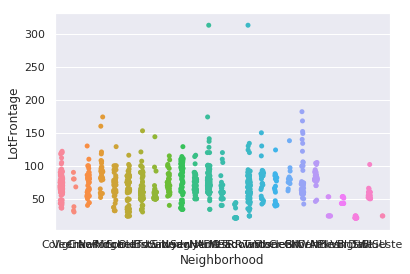

In [27]:
mask = ~df_num['LotFrontage'].isnull()
sns.stripplot(x = 'Neighborhood', y = df_num['LotFrontage'][mask], data = df_cat[mask])
#grid_plot(df_cat[mask], df_num['LotFrontage'][mask], plot_func = sns.stripplot, figsize=(20,50))

Looks like we could train a good model to predict LotFrontage.  
But for now, let's use the simple good ideia to impute with Neighborhood median (there are clearly some outliers).

In [28]:
mask = df_num['LotFrontage'].isnull()
rep_dic = df[['Neighborhood', 'LotFrontage']].groupby('Neighborhood').median().to_dict()['LotFrontage']
df_num.loc[mask, 'LotFrontage'] = df_cat['Neighborhood'][mask].replace(rep_dic)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [29]:
na_info(df_num)

Empty DataFrame
Columns: [dtype, na_count, 0_count, unique_count, na_percent]
Index: []

### Numerical data with a few unique values


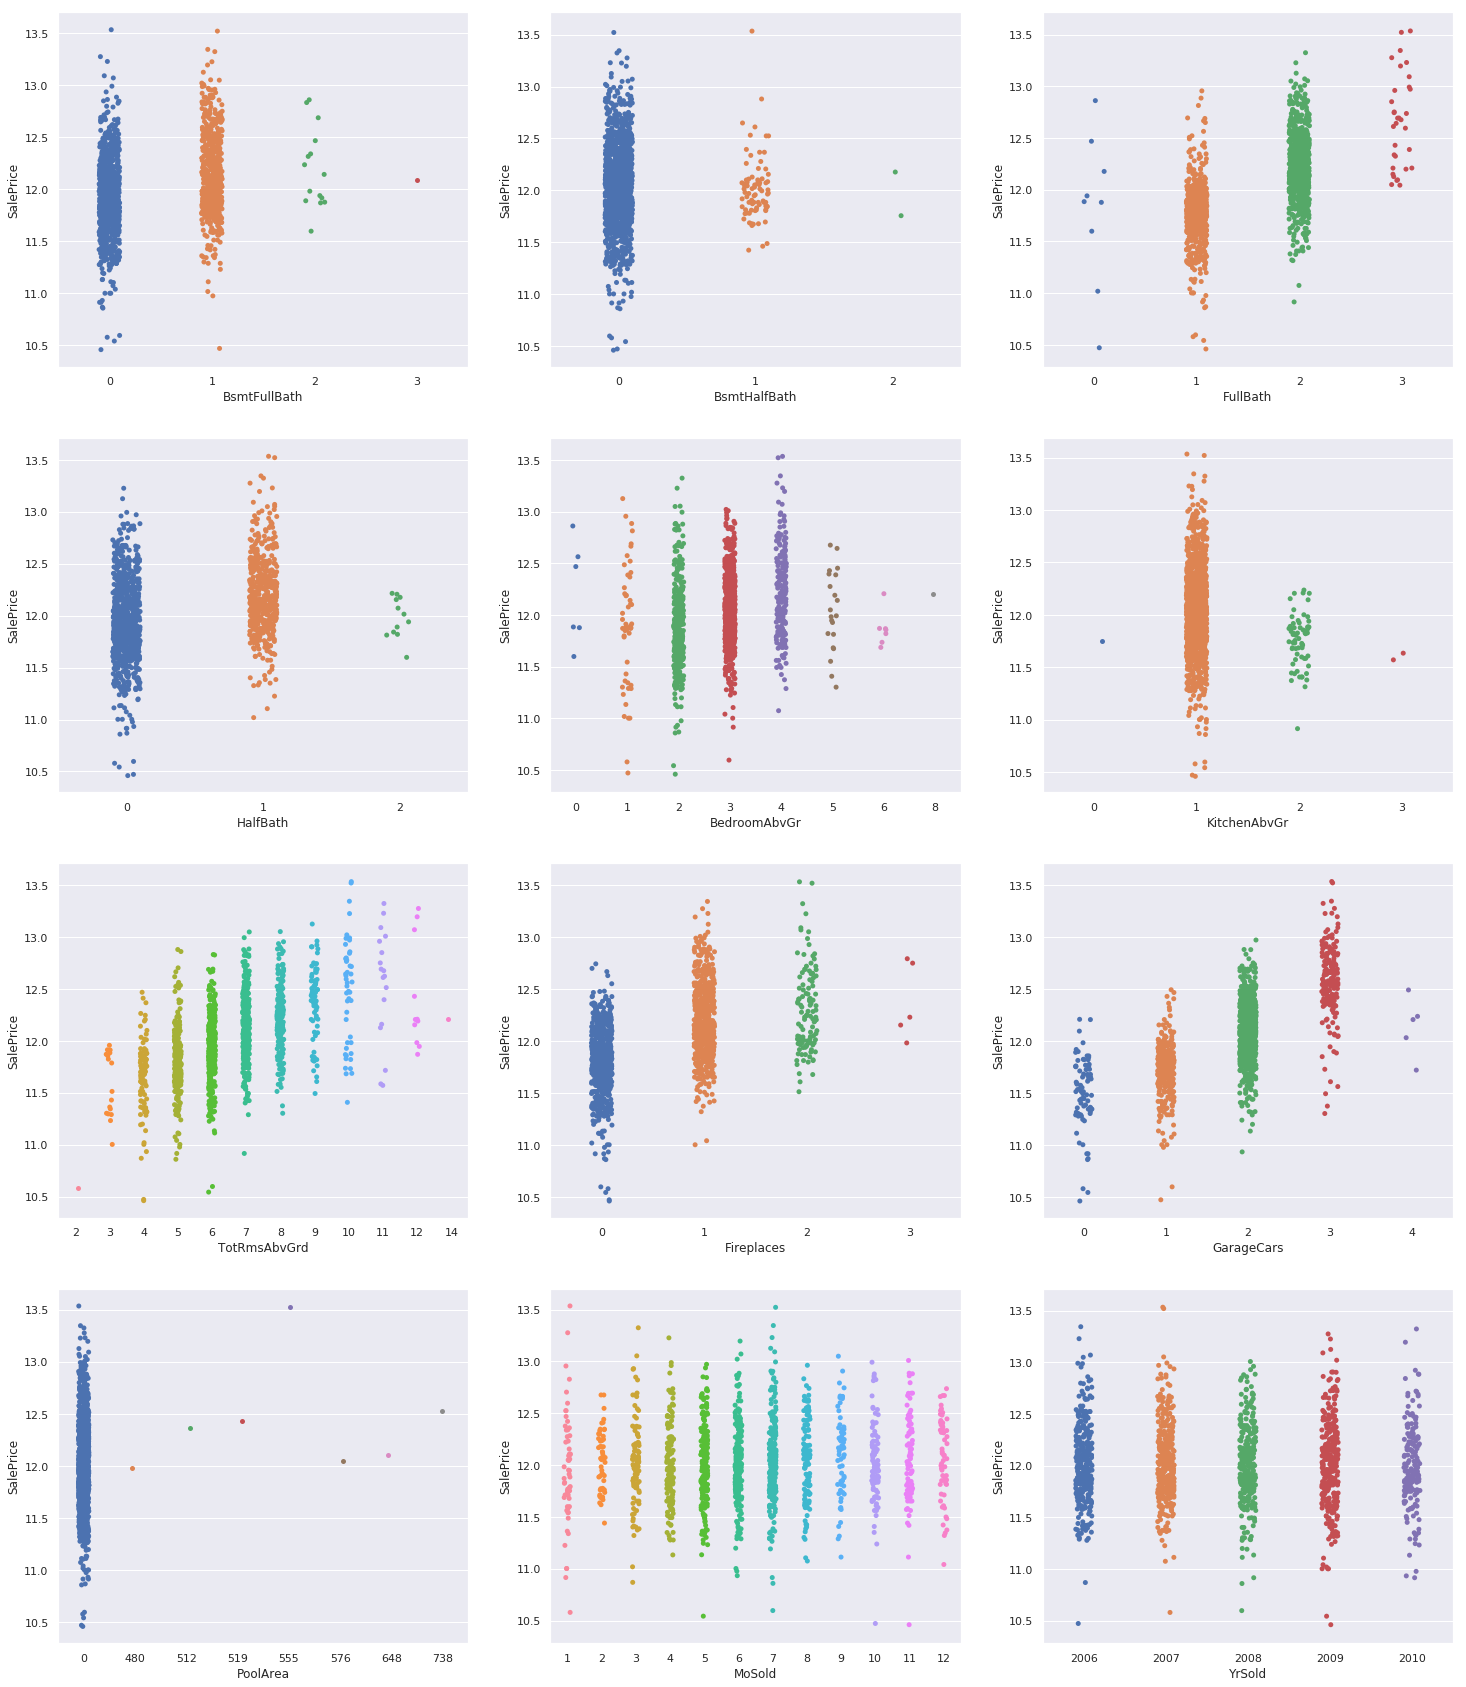

In [30]:
num_info = df_info(df_num)
th_num_boxplot = 15
mask = num_info['unique_count'] <= th_num_boxplot
grid_plot(df_num, y, cols = num_info.index[mask], plot_func= sns.stripplot)

We can see the ordinal relationship of some features to be correlated with SalePrice. Example: TotRmsAbvGrd and FullBath.

On the other side, this not happens with KitchenAbvGr.

### Years

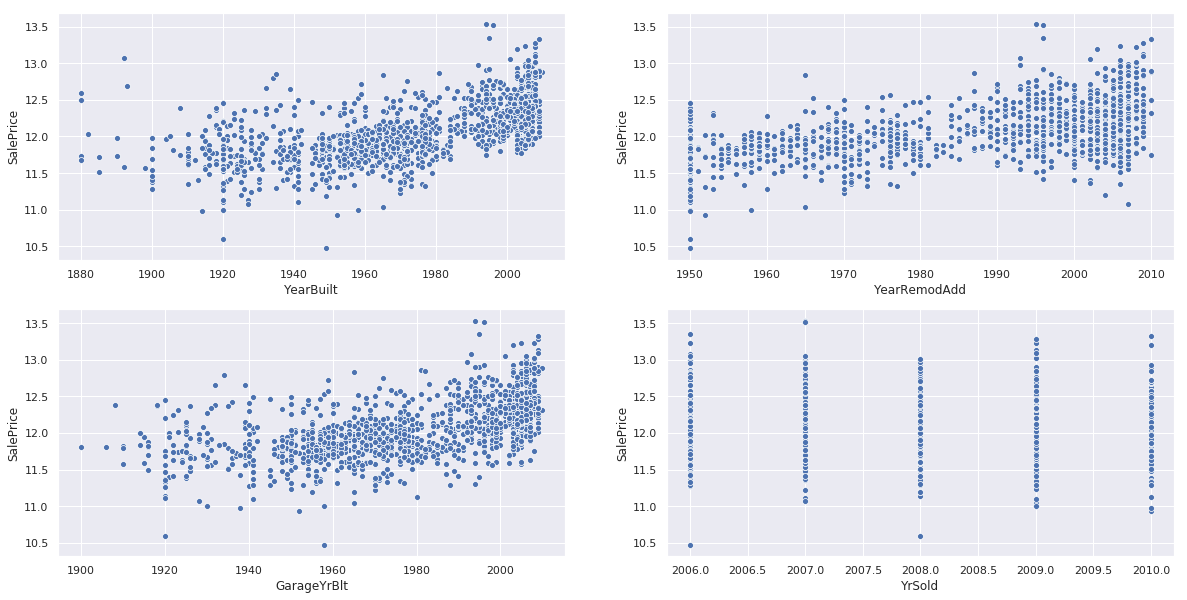

In [31]:
mask = ~ (df_num['GarageYrBlt'] == 0)
grid_plot(df_num[mask], y[mask], plot_func=sns.scatterplot, n_col=2, cols = year_cols, figsize=(20,10))

Maybe there is a super-linear relationship in SalpePrice x YearBuilt.

### Typical numerical data

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


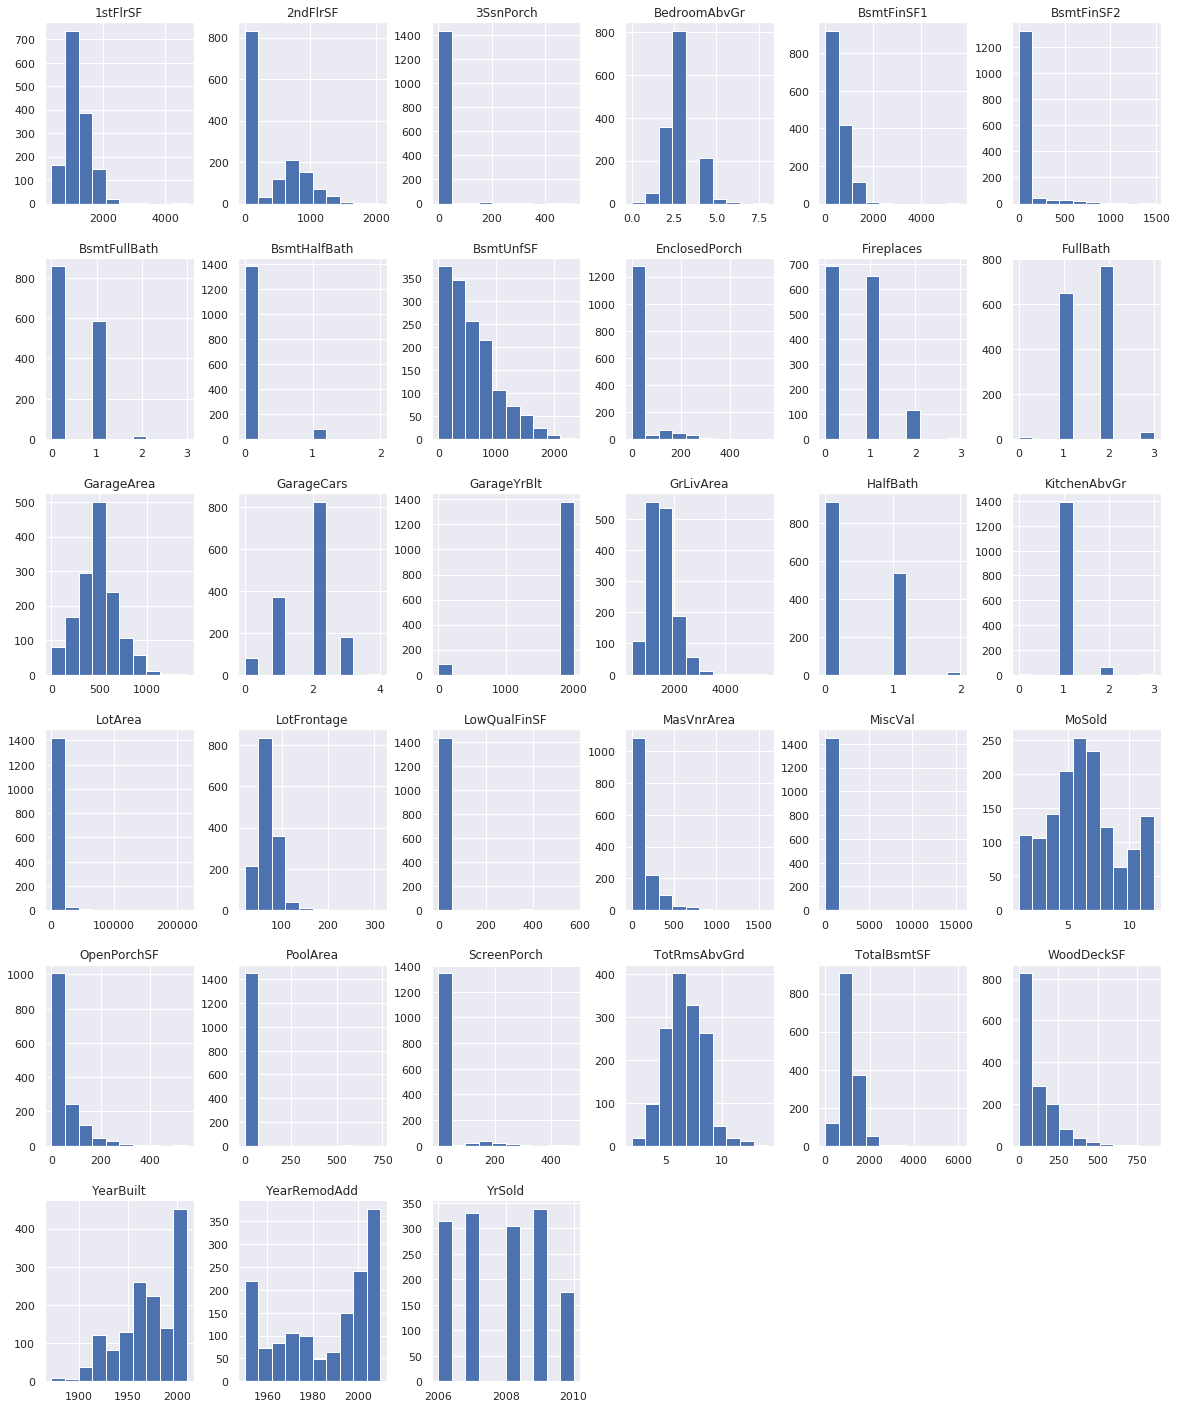

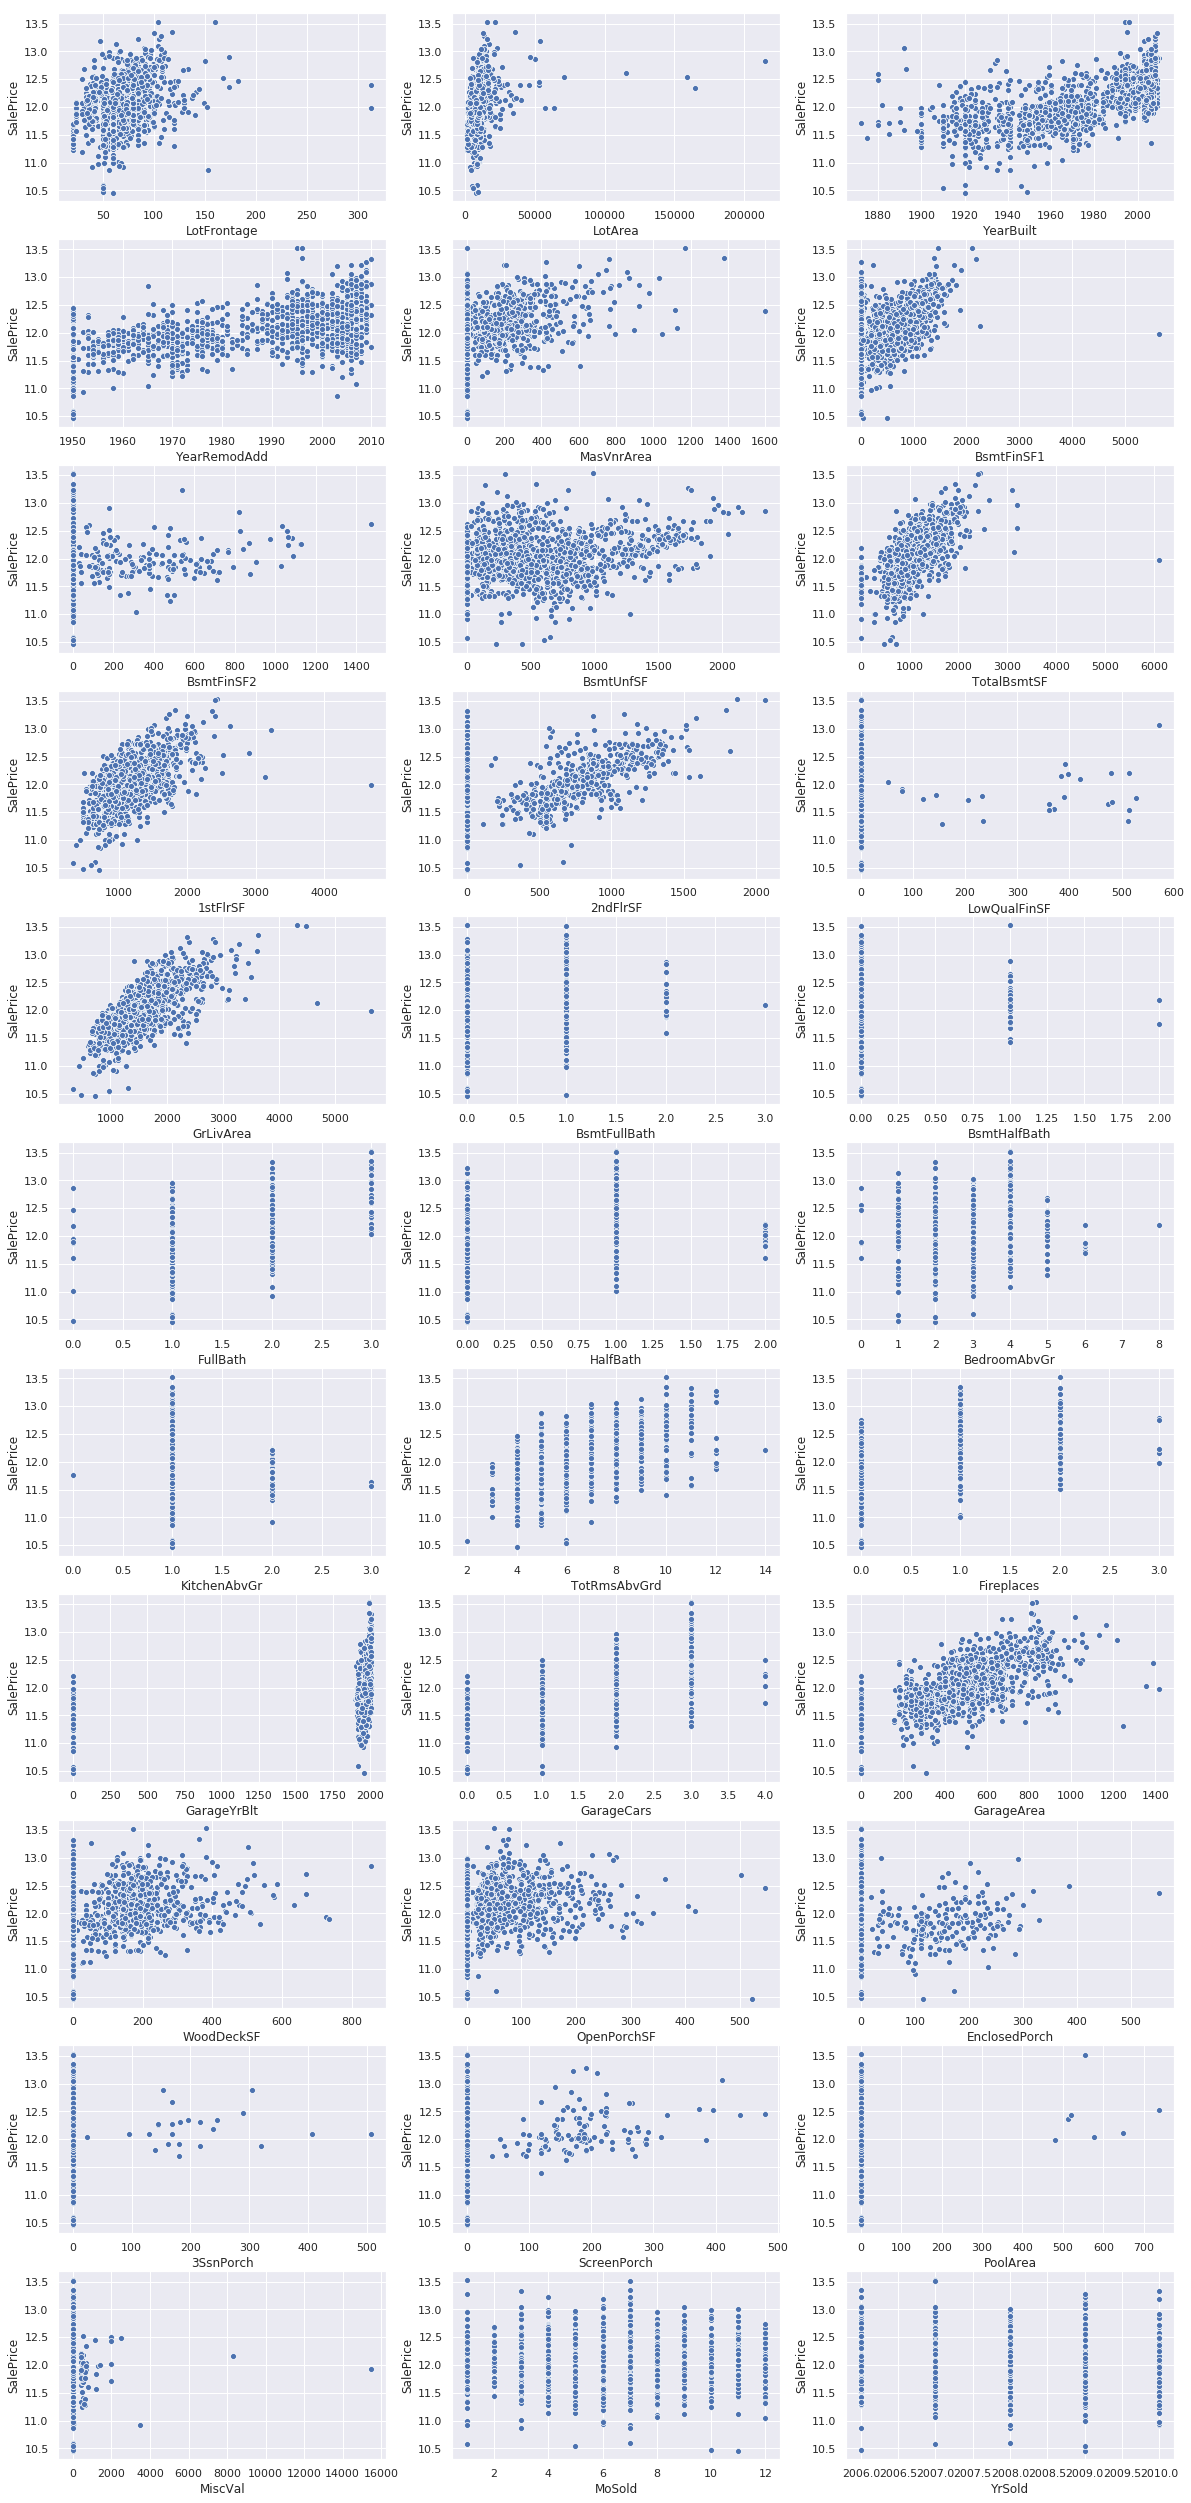

In [32]:
fig, ax = plt.subplots(figsize=(20, 25))
df_num.hist(ax = ax);

grid_plot(df_num, y, plot_func=sns.scatterplot, figsize=(20,45))

### Mutual information score for numerical

In [33]:
mi_good_numeric = list(df_num.columns[mutual_info_regression(df_num.fillna(df_num.mean()), y).argsort()][-1::-1])
print('mi_good_numeric:', mi_good_numeric)

mi_good_numeric: ['GrLivArea', 'GarageCars', 'YearBuilt', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'GarageYrBlt', 'YearRemodAdd', 'LotFrontage', 'TotRmsAbvGrd', '2ndFlrSF', 'LotArea', 'Fireplaces', 'OpenPorchSF', 'BsmtFinSF1', 'BsmtUnfSF', 'WoodDeckSF', 'MasVnrArea', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'EnclosedPorch', 'ScreenPorch', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF2', 'LowQualFinSF', 'MiscVal', 'MoSold', '3SsnPorch', 'PoolArea', 'YrSold']


### Skewed features

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr', 'GarageYrBlt',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')


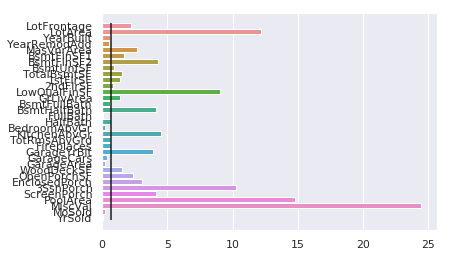

In [34]:
skew_th = 0.7
ax = sns.barplot(x = df_num.apply(lambda s : stats.skew(s)).abs(), y = df_num.columns)
ax.vlines(skew_th, *ax.get_ylim())

mask_skew = df_num.apply(lambda s : stats.skew(s)).abs() > skew_th

print(df_num.columns[mask_skew])

#fig, ax = plt.subplots(figsize=(20, 25))
#df_num.loc[:,mask_skew].hist(ax = ax);

### Applying transformations

Let's apply some transformations to see:

- log transform in skewed data.


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


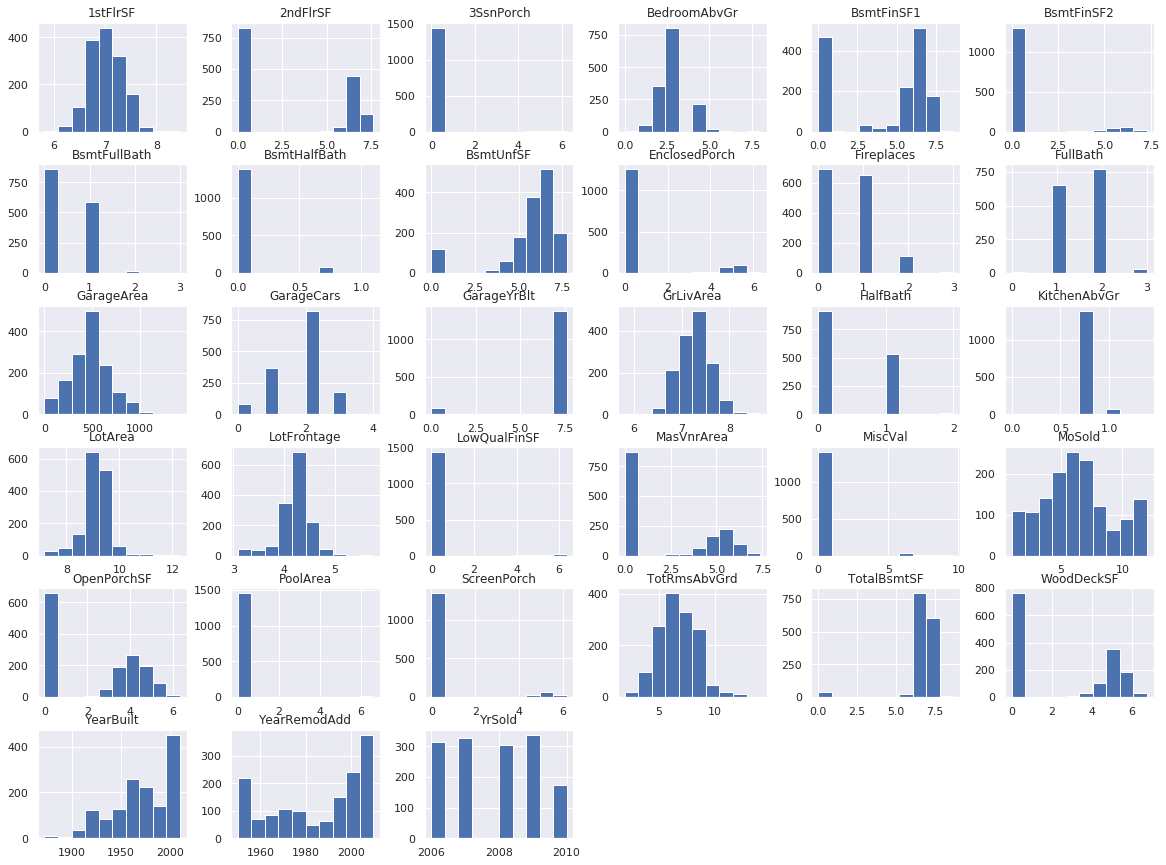

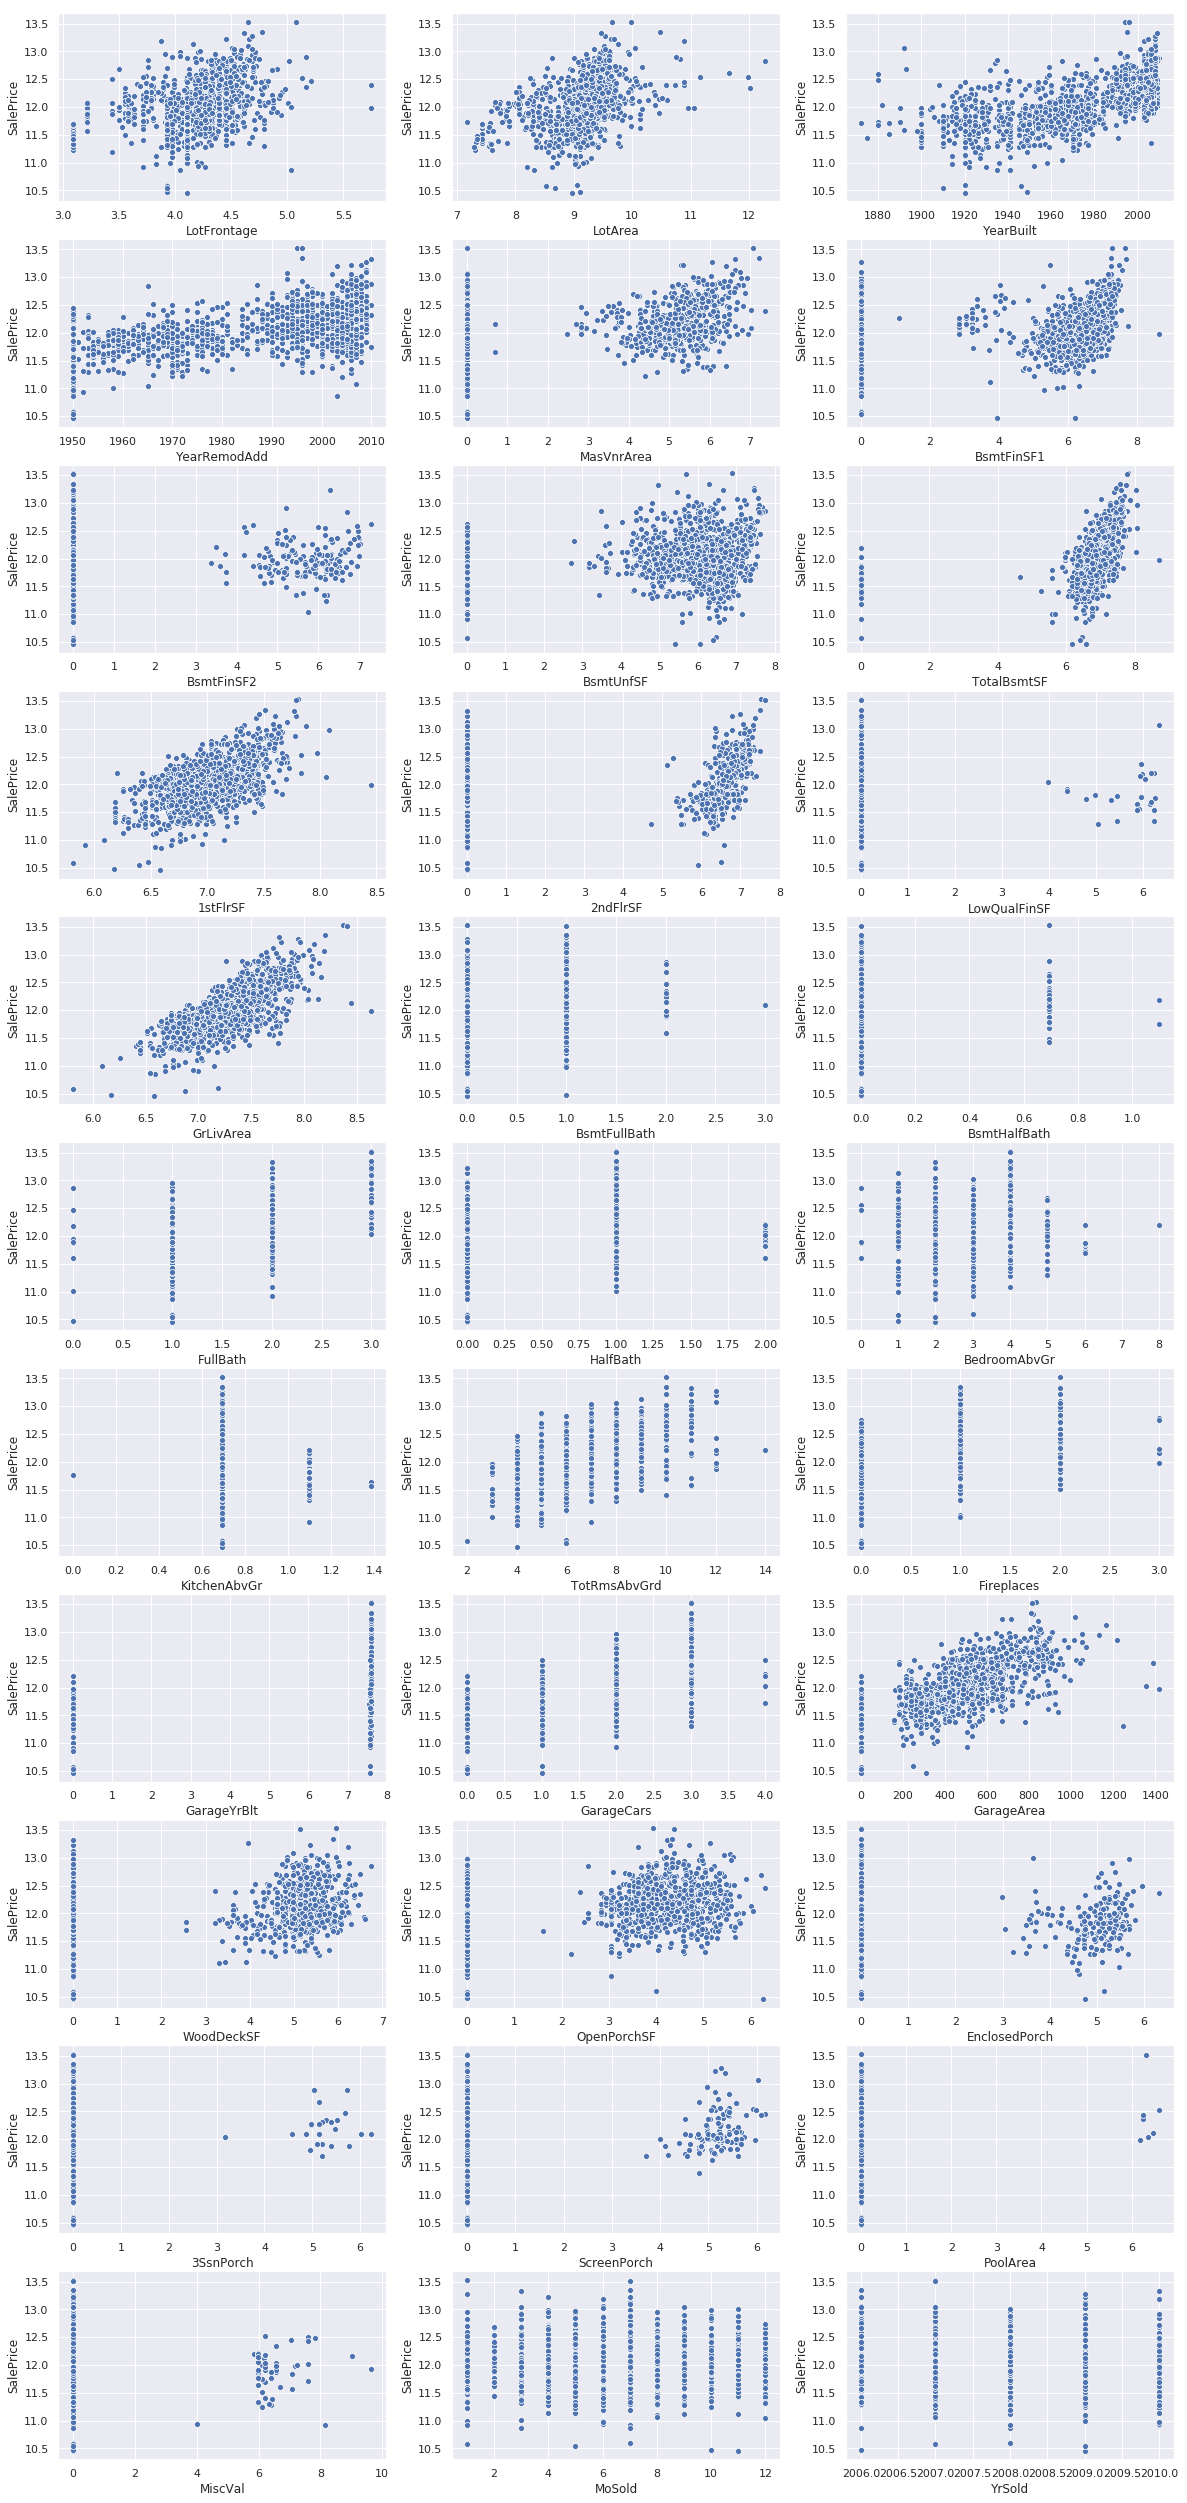

In [35]:
df_num_t = df_num.copy()
"""
df_num_t['LotFrontage'] = np.clip(df_num_t['LotFrontage'] , 0, 180)
df_num_t['1stFlrSF'] = np.clip(df_num_t['1stFlrSF'] , 0, 2200)
df_num_t['2ndFlrSF'] = df_num_t['2ndFlrSF']
df_num_t['BsmtFinSF1'] = np.clip(df_num_t['BsmtFinSF1'], 0, 1800)
df_num_t['GarageArea'] = df_num_t['GarageArea']
df_num_t['GrLivArea'] = np.clip(df_num_t['GrLivArea'], 0, 3000)
df_num_t['LotArea'] = np.log(np.clip(df_num_t['LotArea'], 0, 50000))
df_num_t['MasVnrArea'] = df_num_t['MasVnrArea']
df_num_t['OpenPorchSF'][df_num_t['OpenPorchSF'] > 0] = np.log(df_num_t['OpenPorchSF'][df_num_t['OpenPorchSF'] > 0])
df_num_t['TotalBsmtSF'] = np.clip(df_num_t['TotalBsmtSF'] , 0, 2200)
df_num_t['WoodDeckSF'] = df_num_t['WoodDeckSF']
"""

# log transform skewd features
df_num_t.loc[:, mask_skew] = np.log1p(df_num.loc[:, mask_skew])

# new histograms
fig, ax = plt.subplots(figsize=(20, 15))
df_num_t.hist(ax = ax);

# scatter plots with feature x SalePrice
grid_plot(df_num_t, y, plot_func=sns.scatterplot, figsize=(20,45))

### Correlations

High correlations
TotalBsmtSF 1stFlrSF 0.8195299750050355
1stFlrSF TotalBsmtSF 0.8195299750050355
GrLivArea TotRmsAbvGrd 0.8254893743088377
GrLivArea SalePrice 0.7009266525441293
TotRmsAbvGrd GrLivArea 0.8254893743088377
GarageCars GarageArea 0.8824754142814603
GarageArea GarageCars 0.8824754142814603
SalePrice GrLivArea 0.7009266525441293


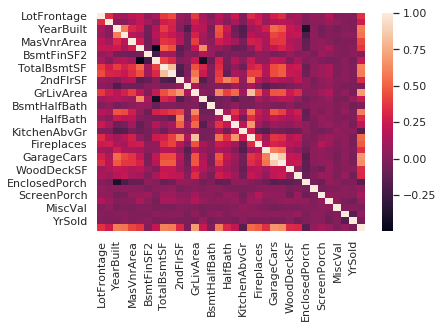

In [36]:
df_corr = pd.concat([df_num, y], axis = 1).corr()

display(sns.heatmap(df_corr))

print('High correlations')
for ((c1,c2),b) in (df_corr.abs() > 0.7).unstack().iteritems():
    if c1 != c2 and b:
        print(c1,c2, df_corr.loc[c1,c2])
        

------------------------

# Models

### NA's in Test Data

In [37]:
df_info(df_test.loc[:, df_test.isnull().sum() > 0])

dtype  na_count  0_count  unique_count
MSZoning       object         4        0             6
LotFrontage   float64       227        0           116
Alley          object      1352        0             3
Utilities      object         2        0             2
Exterior1st    object         1        0            14
Exterior2nd    object         1        0            16
MasVnrType     object        16        0             5
MasVnrArea    float64        15      877           304
BsmtQual       object        44        0             5
BsmtCond       object        45        0             5
BsmtExposure   object        44        0             5
BsmtFinType1   object        42        0             7
BsmtFinSF1    float64         1      462           670
BsmtFinType2   object        42        0             7
BsmtFinSF2    float64         1     1278           162
BsmtUnfSF     float64         1      123           794
TotalBsmtSF   float64         1       41           737
BsmtFullBath  float64         2      849             5
BsmtHalfBath  float64         2     1364             4
KitchenQual    object         1        0             5
Functional     object         2        0             8
FireplaceQu    object       730        0             6
GarageType     object        76        0             7
GarageYrBlt   float64        78        0            98
GarageFinish   object        78        0             4
GarageCars    float64         1       76             7
GarageArea    float64         1       76           460
GarageQual     object        78        0             5
GarageCond     object        78        0             6
PoolQC         object      1456        0             3
Fence          object      1169        0             5
MiscFeature    object      1408        0             4
SaleType       object         1        0            10

In [38]:
from sklearn.model_selection import KFold

def create_submission(name, target_name, df_test, model, tranf_func = lambda x : x):
    if tranf_func is not None:
        df_test_t = tranf_func(df_test)
    
    y_test = model.predict(df_test_t)
    y_test = np.exp(y_test)
    df_sub = pd.DataFrame({'Id' : df_test['Id'] , target_name : y_test})
    print('Submission head:')
    display(df_sub.head())    
    filepath = name + '.csv'
    df_sub.to_csv(filepath, index=False)
    print('Submission created in:', filepath)        
        
def evaluate_model(model, df, y, cv = 5):
    kfold = KFold(n_splits = cv, shuffle=True, random_state=42)
    scores = cross_validate(model, df, y, scoring='neg_mean_squared_error', return_train_score=True, cv = kfold)
    
    print('RMSE train: ', (-scores['train_score'].mean())**0.5, ' +-', scores['train_score'].std()**0.5)
    print('RMSE test: ', (-scores['test_score'].mean())**0.5, ' +-', scores['test_score'].std()**0.5)
    
    model.fit(df,y)    
    y_pred = model.predict(df)
    
    print('Full RMSE train:', mean_squared_error(y, y_pred)**0.5)
    
    if isinstance(model, Pipeline):
        last_model = model.steps[-1][1]
        df_ = Pipeline(model.steps[:-1]).transform(df)
        df_ = pd.DataFrame(df_)
    else:
        last_model = model
        df_ = df
        
    if hasattr(last_model, 'feature_importances_'):
        print('Feature Importances')
        
        fig , ax = plt.subplots(figsize = (10,15))
        sns.barplot(x = 'importance', y = 'feature', 
                    data = pd.DataFrame({'feature' : df_.columns, 'importance' : last_model.feature_importances_})\
                    .sort_values('importance', ascending = False), ax = ax)
        plt.show()
        
    if hasattr(last_model, 'train_score_'):
        print('Train score')
        plt.plot(last_model.train_score_, label = 'train_score')
        plt.show()
    
    print('Real x Predicted')
    fig, ax = plt.subplots()
    sse = (y - y_pred)**2    
    ax = sns.scatterplot(x = y, y = y_pred, hue = sse, ax = ax)
    sns.lineplot(x = y, y = y, ax = ax)    
    ax.set_xlabel('y_real')
    ax.set_ylabel('y_pred')
    ax.legend_.texts[0].set_text('SSE')
    plt.show()
        
    return model

def create_error_df(df_raw, df_model, y, model, name):
    y_pred = model.predict(df_model)
    sse = (y - y_pred)**2
    sse_sign = np.sign(y - y_pred)*sse
    sns.scatterplot(x = y, y = y_pred, hue = sse)
    sns.lineplot(x = y, y = y)
    plt.show()
    df_error = df_raw.copy()
    df_error['y_pred'] = y_pred
    df_error['y'] = y
    df_error['sse'] = sse
    df_error['sse_sign'] = sse_sign
    df_error.index.name = 'idx'
    df_error.sort_values('sse', ascending = False, inplace = True)
    display(df_error.head())
    file = '{}_regression_errors.csv'.format(name)
    print('writing errors in:', file)
    df_error.to_csv(file)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

### Custom Transformer

This is not a sklearn transformer.

In [39]:
class T:
    """
    Impute values to numerical and categorical columns.
    Then apply OHE for selected categoricals.
    
    For numerical columns:
    - Apply log transform to selected columns.
    - Apply binarization to selected columns.
    - Apply discretization (KBinDiscretizer) to selected columns.
    
    
    """
    def __init__(self, bin_th = 0.0, numeric_imputer = None, categorical_imputer = None, log_eps = 1):
        self.bin_th = bin_th
        self.log_eps = log_eps
        
        if numeric_imputer is None:
            self.numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
        else:
            self.numeric_imputer = sk.clone(numeric_imputer)
        
        if categorical_imputer is None:
            self.categorical_imputer = Pipeline([('cat_imputer_None', SimpleImputer(None, strategy='constant', fill_value='NA')),
                                                 ('cat_imputer_nan', SimpleImputer(np.nan, strategy='constant', fill_value='NA'))])
        else:
            self.categorical_imputer = sk.clone(cateforical_imputer)
            
        self.ohe_ = OneHotEncoder(handle_unknown='ignore', sparse=False)
            
                                                
    def _impute_ctg(self, df):
        df_imp = df[self.ctg_cols].copy()
        df_imp[self._ctg_cols_default] = self.categorical_imputer.transform(df[self._ctg_cols_default])
        for col in [c for c in self.ctg_cols if c in self.imp_dict]:
            df_imp[col] = self.imp_dict[col].transform(df_imp[[col]])
        
        return df_imp
    
    def _impute_numerical(self, df):
        df_imp = df[self.num_cols].copy()
        
        df_imp[self._num_cols_default] = self.numeric_imputer.transform(df[self._num_cols_default])
        for col in [c for c in self.num_cols if c in self.imp_dict]:
            df_imp[col] = self.imp_dict[col].transform(df_imp[[col]])
        
        return df_imp
    
    def _fit_ohe(self, df):
        
        if len(self.to_ohe) == 0:
            return
        
        # impute to fit ohe after
        df_ohe = self._impute_ctg(df)[self.to_ohe]
        self.ohe_.fit(df_ohe)
        self.ohe_col_names = self.ohe_.get_feature_names(df_ohe.columns)
        
    
    def _fit_kbin(self, df):
        # tuples with (column_name, n_bins, strategy)
        
        if len(self.to_kbin) == 0:
            return
        
        df_kbin = self._impute_numerical(df)[[t[0] for t in self.to_kbin]]
        
        self.kbin_fit_dict = {}
            
        for col, n_bins, strategy in self.to_kbin:
            kb = KBinsDiscretizer(n_bins=n_bins, strategy=strategy, encode='onehot-dense')            
            kb.fit(df_kbin[[col]])
            
            #todo improve col names
            kb_cols = ['{}_{}{}_{}{}'.format(col, '<' if i == 0 else '', y1, 
                                             y2, '>' if i == (len(kb.bin_edges_[0])-2) else '')
                       for i,(y1,y2) in enumerate(zip(kb.bin_edges_[0] , kb.bin_edges_[0][1:]))]
            
            self.kbin_fit_dict[col] =  kb, kb_cols
        
    
    def fit(self, df, imputer_dict = None, to_keep = [], numerical_cols = [], categorical_cols = [],
            to_ohe = [] , to_log = [], to_bin = [], to_kbin = []):
        
        """
        to_keep: 
            list of columns that will copied as is.
        
        numerical_cols:
            list of columns that will have default numerical imputation (if not present in imputer_dict)
        
        categorical_cols:
            list of columns that will have default categorical imputation (if not present in imputer_dict)
            
        imputer_dict:
            dict with (column_name : imputer_transformer) that will be applied instead of default imputation strategy.
            
        to_ohe (list or str):
            list of columns to be ohe, or 'all' if all categorical_cols
        
        to_log:
            list of columns to be log transformed.
            
        to_bin:
            list of columns to be binarized.
        
        to_kbin:
            lisf of tuples (column_name, n_bins, strategy) with columns to be discretized.
            
        """
        
        self.imp_dict = {col_name : sk.clone(imp) for (col_name,imp) in imputer_dict.items()} if (imputer_dict is not None) else dict()
        self.to_keep = list(to_keep)
        self.num_cols = list(numerical_cols)
        self.ctg_cols = list(categorical_cols)
        self.to_ohe = list(to_ohe) if to_ohe != 'all' else list(categorical_cols)
        self.to_log = list(to_log)
        self.to_bin = list(to_bin)
        self.to_kbin = list(to_kbin)
        
        self._num_cols_default = [col for col in self.num_cols if col not in self.imp_dict]
        self._ctg_cols_default = [col for col in self.ctg_cols if col not in self.imp_dict]
        
        
        # fit imputers in dict
        for col_name, imp in self.imp_dict.items():
            imp.fit(df[[col_name]])
            
        # fit numerical imputer
        if len(self._num_cols_default) > 0:
            self.numeric_imputer.fit(df[self._num_cols_default])
        
        # fit categorical imputer
        if len(self._ctg_cols_default) > 0:
            self.categorical_imputer.fit(df[self._ctg_cols_default])

        # fit ohe
        self._fit_ohe(df)
        
        # fit kbin
        self._fit_kbin(df)
        
        
    def transform(self, df):
        df_ret = pd.DataFrame(index = df.index)
        
        if len(self.to_keep) > 0:
            df_ret[self.to_keep] = df[self.to_keep]
        
        # Numerical transformations
        df_num = self._impute_numerical(df) if len(self.num_cols) > 0 else pd.DataFrame(index = df.index)
        
        if len(self.to_log) > 0:
            df_num[self.to_log] = np.log(df_num[self.to_log] + self.log_eps)
        if len(self.to_bin) > 0:
            df_num[self.to_bin] = (df_num[self.to_bin] > self.bin_th).astype(int)
        
        if len(self.to_kbin) > 0:
            dfs_kbin = []
            for col, (kb_fitted,kb_cols) in self.kbin_fit_dict.items():
                dfs_kbin.append(pd.DataFrame(kb_fitted.transform(df_num[[col]]), columns=kb_cols, index = df_num.index))
            
            df_num.drop([t[0] for t in self.to_kbin], axis = 1, inplace = True)
            df_num = pd.concat([df_num] + dfs_kbin, axis = 1, verify_integrity=True)
        
        # Categorical transformations
        df_ctg = self._impute_ctg(df) if len(self.ctg_cols) > 0 else pd.DataFrame(index = df.index)
        
        if len(self.to_ohe) > 0:
            df_ohe = pd.DataFrame(data = self.ohe_.transform(df_ctg[self.to_ohe]), columns=self.ohe_col_names, index = df_ctg.index)
            df_ctg.drop(self.to_ohe, axis = 1, inplace = True)
            df_ctg = pd.concat([df_ctg, df_ohe], axis = 1, verify_integrity=True)
            
        df_ret = pd.concat([df_ret, df_ctg, df_num], axis = 1, verify_integrity=True)
        
        
        
        return df_ret

## Preprocessing
-------------

### Categoricals

- Every categorical will be imputed with "NA" (or "None" for MasVnrType). 

- Most of them will be OHE transformed.

- Some will be changed to numeric because of it's ordinal nature. Eg. KitchenQual. (only for tree models)

- For tree models, "Neighborhood" is changed to the median neighborhood price in trainning data.

### Numerical

- By default they will be imputed with median.

- LotFrontage is imputed with Neighborhood median value.

- Area features will be imputed with 0.


### Obs

- Two outliers samples were removed.

In [40]:
all_num_cols = list(df_num.columns) + ['OverallCond', 'OverallQual']
area_cols = list(df.columns[((df.columns.str.find('Area') >= 0) | (df.columns.str.find('SF') >= 0))])  
fill_0_cols = area_cols + ['BsmtFullBath', 'BsmtHalfBath'] + ['GarageYrBlt','GarageCars']

my_ctg_cols = df_cat.columns.difference(['OverallQual', 'OverallCond', 'Alley', 'Utilities', 'MSSubClass', 'Condition1', 'Condition2', 'Fence', 'Heating', 'PoolQC'])
ctg_qual_cols = ['KitchenQual', 'ExterQual','ExterCond', 'HeatingQC', 'GarageQual','GarageCond','BsmtQual','BsmtCond','FireplaceQu']
to_ohe = my_ctg_cols.difference(ctg_qual_cols + ['Neighborhood'])

my_t = T()

my_t.fit(df, to_keep=[], numerical_cols = all_num_cols
         , to_bin = []
         , to_log = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                     'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr', 'GarageYrBlt', 
                     'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                     'ScreenPorch', 'PoolArea']
         
         , to_kbin = [] #[(y,10,'uniform') for y in ['YearBuilt']]
         
         , categorical_cols = list(my_ctg_cols)
         
         , to_ohe = list(to_ohe)
         
         , imputer_dict = {'MasVnrType' : SimpleImputer(strategy='constant', fill_value='None')}.update(
             {col : SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0) for col in fill_0_cols})
        )

In [41]:
# some dictionaries that extracts data the trainning dataset as a whole and are used in preprocess

# neighborhood name -> median LotFrontage
neighborhood_to_lot_frontage = df[['Neighborhood', 'LotFrontage']].groupby('Neighborhood').median().to_dict()['LotFrontage']

# neighborhood name -> median log SalePrice
neighborhood_to_log_sale = np.log(df_raw.groupby('Neighborhood').median()['SalePrice']).to_dict()

In [42]:
# lets keep the median/mean SalePrice/TotalSF grouped by some categories
total_sf = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF'].fillna(0)
price_by_sf = df_raw[target_col] / total_sf

price_by_sf_cols = ['Neighborhood']
df_ = df[price_by_sf_cols].copy()
df_['price_by_sf'] = price_by_sf

price_by_sf_dicts = dict()
for col in price_by_sf_cols:
    price_by_sf_dicts[col] = df_.groupby(col).mean()['price_by_sf'].to_dict()

In [43]:
def preproc(df, fitted_transf = my_t, is_lm = False, remove_unimportant = True):
    df_ = df.copy()
    
    # special imputer for LotFrontage
    mask = df_['LotFrontage'].isnull()
    df_.loc[mask, 'LotFrontage'] = df_['Neighborhood'][mask].replace(neighborhood_to_lot_frontage).astype(float)

    # custom transformer
    df_ = fitted_transf.transform(df_)
    
    if not is_lm:
        # Changing neighborhood to mean neighborhood sale price.
        df_.replace({'Neighborhood' : neighborhood_to_log_sale}, inplace = True)
        df_['Neighborhood'] = df_['Neighborhood'].astype(float)

        # Changing some categorical to numerical using it's order
        qual_dic = {'NA' : 0 , 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}
        df_.replace({col : qual_dic for col in ctg_qual_cols}, inplace = True)
        df_[ctg_qual_cols] = df_[ctg_qual_cols].astype(float)
    
    # Creating new features
    df_['TotalSF'] = df_['1stFlrSF'] + df_['2ndFlrSF'] + df_['TotalBsmtSF']
    df_['TotalFullBath'] = df_['FullBath'] + df_['BsmtFullBath']
    df_['TotalHalfBath'] = df_['HalfBath'] + df_['BsmtHalfBath']
    df_['Has_RemodAdd'] = (df_['YearRemodAdd'] != df_['YearBuilt']).astype(int)
    df_['GrLivAreaPerRms'] = df_['GrLivArea'] / df_['TotRmsAbvGrd']
    df_['YearBuilt2'] = df_['YearBuilt']**2    
    df_['OverallCQ'] = df_['OverallCond']*df_['OverallQual']
    
    # creating estimates of log(SalePrice) using median sale_price_by_sf dicts
    for col in price_by_sf_dicts.keys():
        df_['price_by_sf_by_{}'.format(col)] = df[col].apply(lambda n : price_by_sf_dicts[col][n])
        #df_['log_price_sf_estimate_{}'.format(col)] = np.log(df_['price_by_sf_by_{}'.format(col)]*df_['TotalSF'])
    
    if not is_lm:
        df_['ExterCQ'] = df_['ExterQual']*df_['ExterCond']
        df_['BsmtCQ'] = df_['BsmtCond']*df_['BsmtQual']
        df_['GarageCQ'] = df_['GarageCond']*df_['GarageQual']
        df_['CQ_all'] = df_['OverallCQ'] * df_['BsmtCQ'] * df_['KitchenQual'] * df_['GarageCQ'] * df_['ExterCQ']
    
    df_['Age1'] = df_['YrSold'] - df_['YearBuilt']
    df_['Age2'] = df_['YrSold'] - df_['YearRemodAdd']
    
    if remove_unimportant:
        # droped based on low feature importance
        df_.drop(['Electrical_Mix', 'SaleType_CWD', 'Exterior2nd_Other', 'Functional_Sev',
           'RoofMatl_ClyTile', 'Foundation_Wood', 'Electrical_NA',
           'Exterior2nd_CBlock', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm',
           'SaleCondition_AdjLand', 'Exterior1st_CBlock', 'RoofMatl_Membran',
           'Exterior1st_ImStucc', 'RoofMatl_Metal', 'RoofMatl_Roll',
           'Exterior1st_Stone', 'RoofStyle_Shed', 'MiscFeature_TenC',
           'SaleType_Con', 'Exterior2nd_AsphShn', 'RoofMatl_WdShake',
           'MiscFeature_Othr', 'SaleType_Oth', 'SaleType_ConLw', 'LotConfig_FR3',
           'MiscFeature_Gar2', 'Electrical_FuseP', 'MasVnrType_NA',
           'Exterior2nd_ImStucc', 'Foundation_Stone', 'Exterior2nd_Brk Cmn',
           'Exterior2nd_Stone', 'RoofStyle_Mansard', 'SaleType_ConLI',
           'HouseStyle_2.5Fin', 'GarageType_2Types', 'Street_Pave', 'Street_Grvl',
           'PoolArea', 'LotShape_IR3', 'SaleType_ConLD', 'RoofMatl_Tar&Grv',
           'HouseStyle_2.5Unf', 'BsmtFinType2_GLQ', 'SaleCondition_Alloca',
           'HouseStyle_1.5Unf', 'RoofStyle_Gambrel', 'Functional_Maj2',
           'RoofStyle_Flat', 'LandSlope_Sev', 'RoofMatl_WdShngl', 'MSZoning_RH',
           'GarageType_Basment', 'BsmtFinType2_ALQ', 'GarageType_CarPort',
           'Functional_Min1', 'MasVnrType_BrkCmn', 'LowQualFinSF', '3SsnPorch',
           'Functional_Maj1', 'Exterior1st_WdShing', 'BsmtFinType2_BLQ',
           'BsmtFinType2_LwQ', 'Exterior2nd_AsbShng', 'Functional_Mod',
           'HouseStyle_SFoyer', 'Foundation_Slab', 'MSZoning_C (all)',
           'Exterior2nd_BrkFace', 'MiscFeature_Shed', 'Exterior1st_AsbShng',
           'BsmtFinType2_Rec', 'SaleCondition_Family', 'PavedDrive_P',
           'Functional_Min2', 'MiscFeature_NA', 'Exterior1st_Stucco',
           'SaleType_COD', 'BsmtHalfBath', 'HouseStyle_SLvl',
           'Exterior2nd_Wd Shng', 'Exterior2nd_Stucco', 'BsmtExposure_Mn',
           'BldgType_2fmCon', 'LotConfig_FR2', 'MSZoning_FV', 'BsmtFinType1_LwQ',
           'LandContour_HLS', 'LotShape_IR2', 'Electrical_FuseF',
           'RoofMatl_CompShg', 'MiscVal', 'BsmtExposure_NA', 'BsmtFinType2_Unf',
           'Exterior1st_Plywood', 'Exterior2nd_HdBoard', 'LandContour_Low',
           'BsmtFinType1_BLQ', 'BldgType_Twnhs'], axis = 1, inplace = True)
    
    return df_

df_train = df.copy()
df_train.drop([1298, 523],inplace=True)
y_train = y.copy()
y_train = y.drop([1298,523], axis = 0)

df_basic = preproc(df_train, my_t)

preproc_transformer = FunctionTransformer(func=preproc, validate=False)
print(df_basic.shape)

(1458, 119)


In [44]:
display(df_info(preproc_transformer.transform(df_train)))

dtype      ...       unique_count
BsmtCond                     float64      ...                  5
BsmtQual                     float64      ...                  5
ExterCond                    float64      ...                  5
ExterQual                    float64      ...                  4
FireplaceQu                  float64      ...                  6
GarageCond                   float64      ...                  6
GarageQual                   float64      ...                  6
HeatingQC                    float64      ...                  5
KitchenQual                  float64      ...                  4
Neighborhood                 float64      ...                 25
BldgType_1Fam                float64      ...                  2
BldgType_Duplex              float64      ...                  2
BldgType_TwnhsE              float64      ...                  2
BsmtExposure_Av              float64      ...                  2
BsmtExposure_Gd              float64      ...                  2
BsmtExposure_No              float64      ...                  2
BsmtFinType1_ALQ             float64      ...                  2
BsmtFinType1_GLQ             float64      ...                  2
BsmtFinType1_NA              float64      ...                  2
BsmtFinType1_Rec             float64      ...                  2
BsmtFinType1_Unf             float64      ...                  2
BsmtFinType2_NA              float64      ...                  2
CentralAir_N                 float64      ...                  2
CentralAir_Y                 float64      ...                  2
Electrical_FuseA             float64      ...                  2
Electrical_SBrkr             float64      ...                  2
Exterior1st_BrkFace          float64      ...                  2
Exterior1st_CemntBd          float64      ...                  2
Exterior1st_HdBoard          float64      ...                  2
Exterior1st_MetalSd          float64      ...                  2
Exterior1st_VinylSd          float64      ...                  2
Exterior1st_Wd Sdng          float64      ...                  2
Exterior2nd_CmentBd          float64      ...                  2
Exterior2nd_MetalSd          float64      ...                  2
Exterior2nd_Plywood          float64      ...                  2
Exterior2nd_VinylSd          float64      ...                  2
Exterior2nd_Wd Sdng          float64      ...                  2
Foundation_BrkTil            float64      ...                  2
Foundation_CBlock            float64      ...                  2
Foundation_PConc             float64      ...                  2
Functional_Typ               float64      ...                  2
GarageFinish_Fin             float64      ...                  2
GarageFinish_NA              float64      ...                  2
GarageFinish_RFn             float64      ...                  2
GarageFinish_Unf             float64      ...                  2
GarageType_Attchd            float64      ...                  2
GarageType_BuiltIn           float64      ...                  2
GarageType_Detchd            float64      ...                  2
GarageType_NA                float64      ...                  2
HouseStyle_1.5Fin            float64      ...                  2
HouseStyle_1Story            float64      ...                  2
HouseStyle_2Story            float64      ...                  2
LandContour_Bnk              float64      ...                  2
LandContour_Lvl              float64      ...                  2
LandSlope_Gtl                float64      ...                  2
LandSlope_Mod                float64      ...                  2
LotConfig_Corner             float64      ...                  2
LotConfig_CulDSac            float64      ...                  2
LotConfig_Inside             float64      ...                  2
LotShape_IR1                 float64      ...                  2
LotShape_Reg                 float64      ...                  2
M

### RandomForest

RMSE train:  0.09612263180235017  +- 0.014716677813860626
RMSE test:  0.13704412858431206  +- 0.05134921829475099
Full RMSE train: 0.0977636713655228
Feature Importances


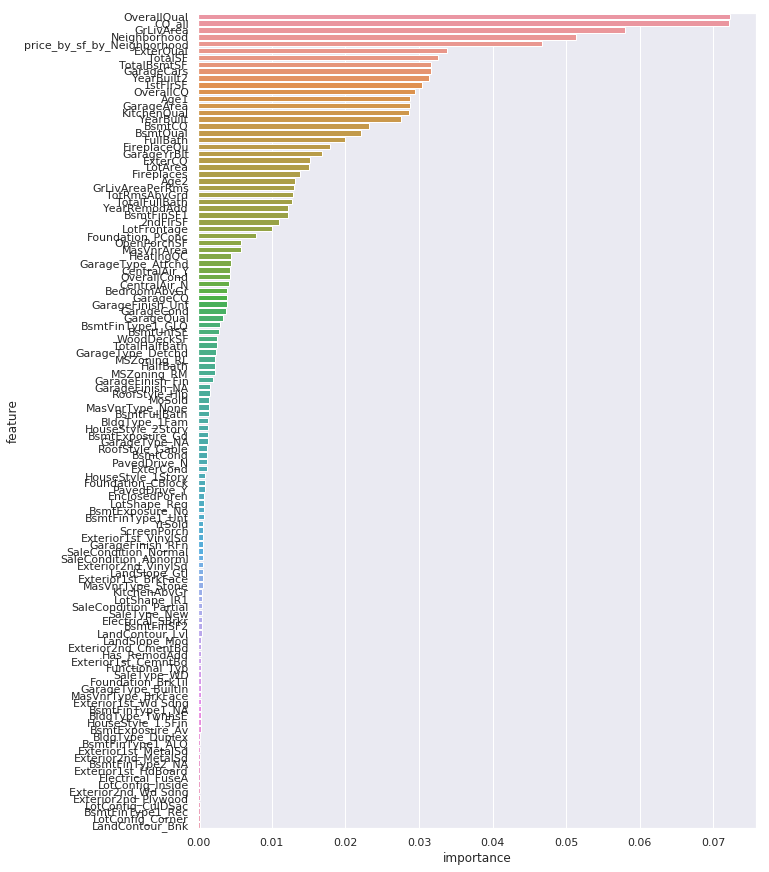

Real x Predicted


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


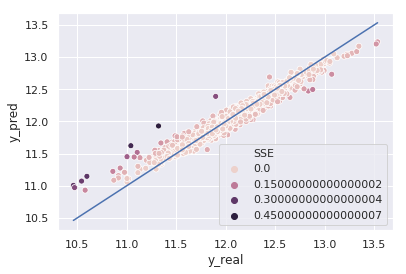

CPU times: user 1min 3s, sys: 1.02 s, total: 1min 4s
Wall time: 1min 2s


In [45]:
%%time

rf_basic = RandomForestRegressor(n_estimators=5000, max_features=8, max_depth = 8, min_impurity_decrease = 0.0,  min_samples_split = 8, bootstrap=True, random_state=42)
rf_pipe = Pipeline([('preproc', preproc_transformer), ('rf', rf_basic)])
rf_pipe = evaluate_model(rf_pipe, df_train, y_train, cv = 5);

In [46]:
create_submission('rf_pipe', target_col, df_test, rf_pipe)

Submission head:


Id      SalePrice
0  1461  126757.309383
1  1462  148457.029491
2  1463  179454.837682
3  1464  185985.918218
4  1465  199231.143071

Submission created in: rf_pipe.csv


### GradientBoosting

RMSE train:  0.09154817819152049  +- 0.024287671002212057  
RMSE test:  0.11953453027303786  +- 0.06115475678864922  
Full RMSE train: 0.09315005471625645

RMSE train:  0.07827894156092431  +- 0.015820097672588265
RMSE test:  0.111801033761706  +- 0.040991758422471665
Full RMSE train: 0.08000905397324937
Feature Importances


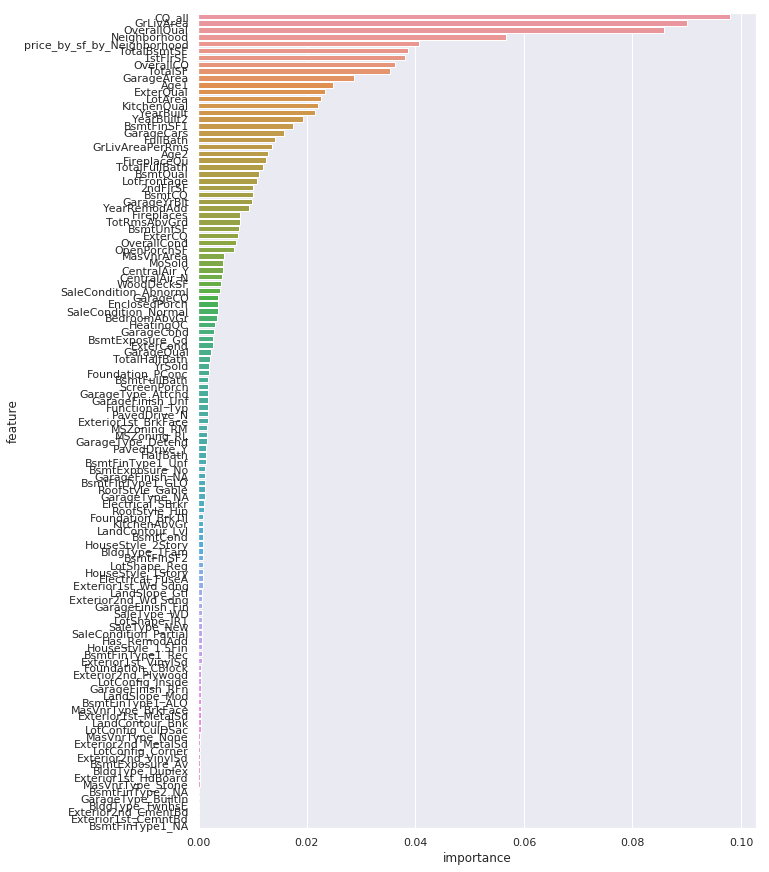

Train score


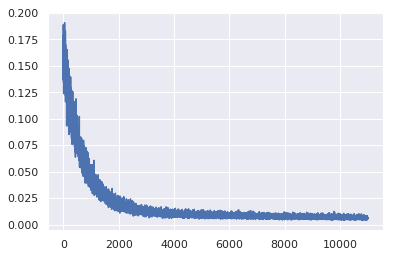

Real x Predicted


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


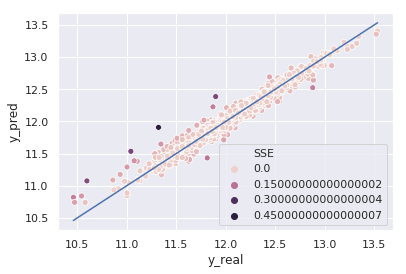

CPU times: user 1min 7s, sys: 1.35 s, total: 1min 8s
Wall time: 1min 6s


In [47]:
%%time

#Single model based on good models found by Random Grid Serach CV

gb_basic = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.001, loss='ls', max_depth=4,
             max_features=20, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=3, min_samples_split=8,
             min_weight_fraction_leaf=0.0, n_estimators=11000,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=0.15, tol=0.0001, validation_fraction=0.2, verbose=0,
             warm_start=False)

gb_pipe = Pipeline([('preproc', preproc_transformer), ('gb', gb_basic)])

gb_pipe = evaluate_model(gb_pipe, df_train, y_train, cv = 5);

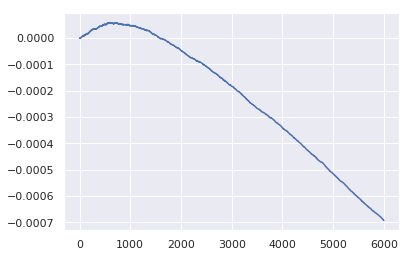

In [48]:
plt.plot(np.cumsum(gb_basic.oob_improvement_[5000:]))

In [49]:
create_submission('gb_pipe', target_col, df_test, gb_pipe)

Submission head:


Id      SalePrice
0  1461  128072.564788
1  1462  156969.716745
2  1463  182439.823444
3  1464  187323.327699
4  1465  192359.448427

Submission created in: gb_pipe.csv


## XGBoost

RMSE train:  0.08150784179763836  +- 0.015060684733993532
RMSE test:  0.11907010336057633  +- 0.04859568491458574
Full RMSE train: 0.08258768781122049
Feature Importances


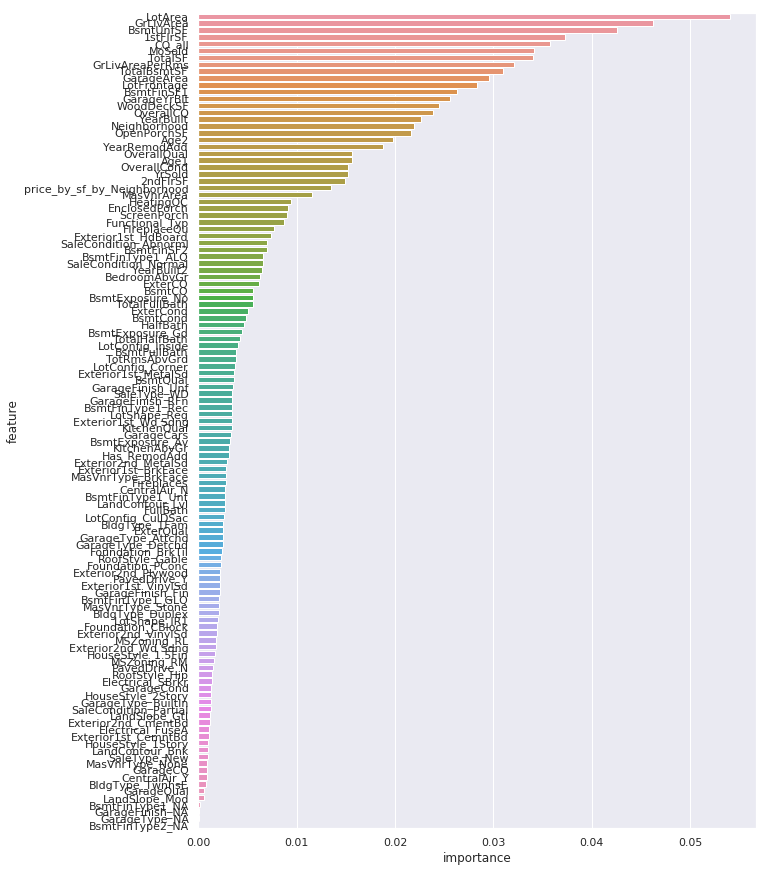

Real x Predicted


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


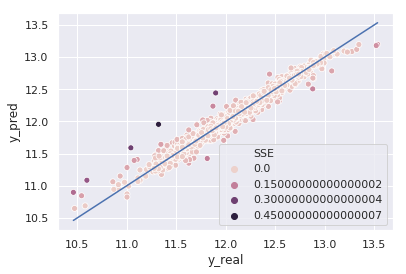

CPU times: user 52.1 s, sys: 1.26 s, total: 53.4 s
Wall time: 52.2 s


In [50]:
%%time


xgb_basic = XGBRegressor(max_depth=4, learning_rate=0.01, n_estimators=2000, silent=True, objective='reg:linear', booster='gbtree',
                         n_jobs=1, nthread=None, gamma=0, min_child_weight=3, max_delta_step=0, subsample=0.3, colsample_bytree=0.7, 
                         colsample_bylevel=1, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, base_score=0.5, 
                         random_state=42, missing=None)


xgb_pipe = Pipeline([('preproc', preproc_transformer),('xgb', xgb_basic)])
xgb_pipe = evaluate_model(xgb_pipe, df_train, y_train, cv = 5);

## Linear Models

For linear models it's better to use Neighborhood in OHE form.

In [51]:
lm_t = T()

lm_t.fit(df, to_keep=[], numerical_cols = all_num_cols
         , to_bin = []
         , to_log = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                     'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr', 'GarageYrBlt', 
                     'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                     'ScreenPorch', 'PoolArea']
         
         , to_kbin = [] #[(y,10,'uniform') for y in ['YearBuilt']]
         
         , categorical_cols = list(my_ctg_cols)
         
         , to_ohe = list(to_ohe) + ['Neighborhood'] + ctg_qual_cols
         
         , imputer_dict = {'MasVnrType' : SimpleImputer(strategy='constant', fill_value='None')}.update(
             {col : SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0) for col in fill_0_cols})
        )

preproc_lm = lambda df : preproc(df, fitted_transf=lm_t, is_lm=True)
preproc_transformer_lm = FunctionTransformer(preproc_lm, validate = False)
lm_cols = preproc_lm(df_train).columns

RMSE train:  0.10596183504694068  +- 0.02065908397672398
RMSE test:  0.11494920664536512  +- 0.045492886790151656
Full RMSE train: 0.10726332429212021
Real x Predicted


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


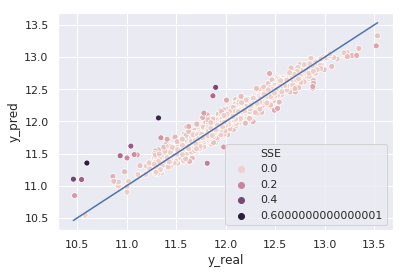

cols     coef_
147                    GrLivArea  0.165976
174                         Age1  0.068293
173  price_by_sf_by_Neighborhood  0.067786
30                Functional_Typ  0.065325
165                  OverallQual  0.060583

CPU times: user 8.46 s, sys: 3.44 s, total: 11.9 s
Wall time: 7.32 s


In [52]:
%%time

lasso = Lasso(alpha = 0.0009, max_iter=11000, tol= 1e-4, random_state=42) #LassoCV(normalize=True, max_iter=1000, random_state=42, n_alphas=5000, cv = kfold)
lasso_pipe = Pipeline([('preproc', preproc_transformer_lm),('scaler', RobustScaler()), ('lasso', lasso)])

lasso_pipe = evaluate_model(lasso_pipe, df_train, y_train, cv = 5);

display(pd.DataFrame({'cols' : lm_cols , 'coef_' : np.abs(lasso_pipe.steps[-1][1].coef_) }).sort_values('coef_', ascending = False).head())
#print('alpha:', lasso_pipe.steps[-1][1].alpha_)

In [53]:
create_submission('lasso_pipe', 'SalePrice', df_test, lasso_pipe)

Submission head:


Id      SalePrice
0  1461  122557.775927
1  1462  154420.681722
2  1463  182221.992934
3  1464  203307.470763
4  1465  203753.177267

Submission created in: lasso_pipe.csv


### SVM

RMSE train:  0.09880165671554826  +- 0.01969300787878662
RMSE test:  0.11406002524392554  +- 0.04514019917055188
Full RMSE train: 0.09891093210383527
Real x Predicted


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


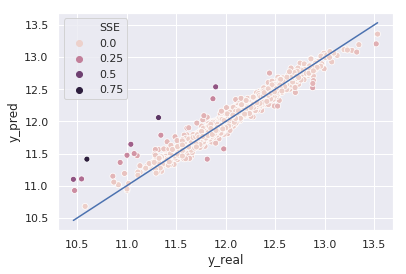

CPU times: user 7.36 s, sys: 836 ms, total: 8.2 s
Wall time: 7.2 s


In [54]:
%%time

svr = SVR(kernel='rbf', gamma = 0.001, C = 6.0, shrinking=True)
svr_pipe = Pipeline([('preproc', preproc_transformer_lm),('scaler', RobustScaler()) , ('svm', svr)]) 
svr_pipe = evaluate_model(svr_pipe, df_train, y_train, cv = 5);

In [55]:
create_submission('svm_pipe', 'SalePrice', df_test, svr_pipe)

Submission head:


Id      SalePrice
0  1461  123786.252638
1  1462  157367.060313
2  1463  185499.498556
3  1464  202745.829957
4  1465  195292.427791

Submission created in: svm_pipe.csv


# Stacking

## Simple Stacking

Weighted average of models predictions

In [56]:
class simple_stack(BaseEstimator, RegressorMixin):
    
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights

    def fit(self, X, y):
        self.fitted_models_ = [sk.clone(m).fit(X,y) for m in self.models]
        
        return self
    
    def predict(self, X):
        preds = list(map(lambda m: m.predict(X), self.fitted_models_))
        preds = np.vstack(preds).T #(n_samples,n_models)
        weights = np.array(self.weights, ndmin=1).reshape(1, -1) # (1, n_models)
        
        y_pred = np.sum(preds * weights, axis = 1)
        return y_pred

RMSE train:  0.08516462480444481  +- 0.017425270278928654
RMSE test:  0.1105271620904921  +- 0.04408403052785472
Full RMSE train: 0.08645776675666363
Real x Predicted


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


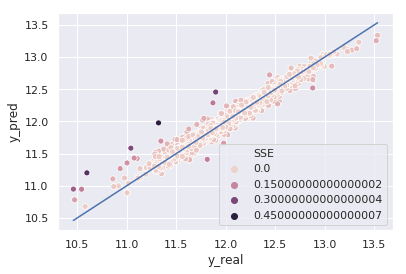

CPU times: user 1min 59s, sys: 3.82 s, total: 2min 3s
Wall time: 1min 58s


In [57]:
%%time
my_simple_stack = simple_stack(models=[gb_pipe, xgb_pipe, lasso_pipe, svr_pipe],weights=[0.4,0.2,0.2,0.2])

evaluate_model(my_simple_stack, df_train, y_train, cv = 5)

Without drop:  
LB 0.11888

With drop:  
LB 0.11815

In [58]:
create_submission('simple_stack', 'SalePrice', df_test, my_simple_stack, lambda x : x)

Submission head:


Id      SalePrice
0  1461  125771.374579
1  1462  156678.710429
2  1463  183163.728106
3  1464  192813.935976
4  1465  194553.251651

Submission created in: simple_stack.csv


## Complex Stacking

Uses cv to generate out-of-fold predictions of every model and then train a meta-model using these predictions as features.

In [59]:
class complex_stack(BaseEstimator, RegressorMixin):
    
    def __init__(self, models, cv = KFold(5, random_state=42), meta_model = None):
        self.models = models
        self.cv = cv
        self.meta_model = meta_model

    def fit(self, X, y):
        self.fitted_models_ = [sk.clone(m).fit(X,y) for m in self.models]
    
        cv_preds = list(map(lambda m : cross_val_predict(m,X,y,cv=self.cv) , self.models))
        cv_preds = np.vstack(cv_preds).T #(n_samples, n_models)
        
        # creating indicator feature for levels of predicted values
        mean_pred = cv_preds.mean(axis = 1, keepdims = True) #(n_samples, 1)
        self.kb_ = KBinsDiscretizer(5, encode='onehot-dense', strategy='uniform')
        pred_ohe = self.kb_.fit_transform(mean_pred) #(n_samples, 5)
        
        features = np.hstack([cv_preds, pred_ohe]) #(n_samples, n_models + 5)
        self.features_ = features
        
        if self.meta_model is None:
            self.meta_model_ = Lasso(alpha=0.01, max_iter=10000, random_state=42)
        else:
            self.meta_model_ = sk.clone(self.meta_model)
        
        self.meta_model_.fit(features,y)
        self.meta_model_score_ = self.meta_model_.score(features, y)
        
        return self
    
    def predict(self, X):
        preds = list(map(lambda m: m.predict(X), self.fitted_models_))
        preds = np.vstack(preds).T #(n_samples,n_models)
        pred_ohe = self.kb_.transform(preds.mean(axis=1, keepdims=True))
        features = np.hstack([preds,pred_ohe])
        
        y_pred = self.meta_model_.predict(features)
        
        return y_pred

lasso_huber_True_False
RMSE train:  0.08635847466107645  +- 0.02436966978333934
RMSE test:  0.11129764128894984  +- 0.031665192042139356
Full RMSE train: 0.08929516168504774
Real x Predicted


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


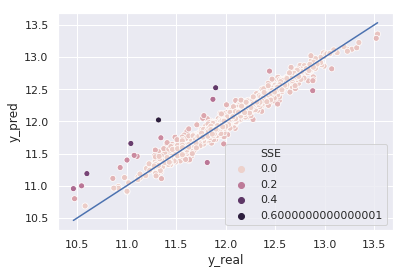

Submission head:


Id      SalePrice
0  1461  127062.654505
1  1462  154856.113678
2  1463  184263.937439
3  1464  198696.633956
4  1465  193053.894078

Submission created in: complex_stack_lasso_huber_True_False.csv
lasso_huber_True_True
RMSE train:  0.08597076059477665  +- 0.027762635076820148
RMSE test:  0.11196603115107293  +- 0.03144397709020531
Full RMSE train: 0.08730342805034932
Real x Predicted


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


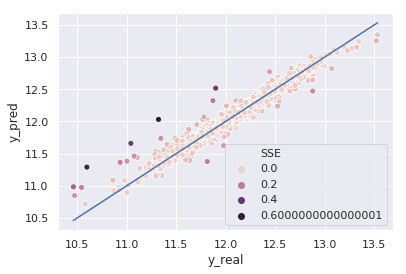

Submission head:


Id      SalePrice
0  1461  126587.287154
1  1462  158304.038974
2  1463  183873.635212
3  1464  197250.085751
4  1465  191915.934633

Submission created in: complex_stack_lasso_huber_True_True.csv
lasso_huber_False_False
RMSE train:  0.08462876083208437  +- 0.021704596364441928
RMSE test:  0.11106771880105962  +- 0.03069469875993605
Full RMSE train: 0.08787883546216403
Real x Predicted


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


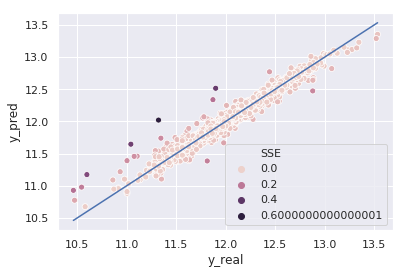

Submission head:


Id      SalePrice
0  1461  126982.351368
1  1462  154957.529185
2  1463  183633.601045
3  1464  195120.948852
4  1465  191812.816852

Submission created in: complex_stack_lasso_huber_False_False.csv
lasso_huber_False_True
RMSE train:  0.08415884911657383  +- 0.025541103191177986
RMSE test:  0.11201929737088145  +- 0.030625729283802028
Full RMSE train: 0.08590123170000155
Real x Predicted


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


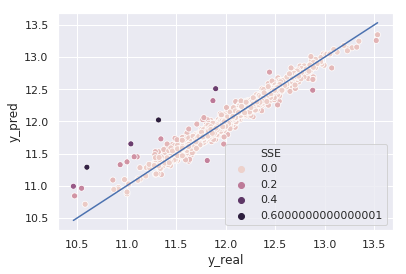

Submission head:


Id      SalePrice
0  1461  126432.353632
1  1462  158375.858987
2  1463  183750.485105
3  1464  194199.307239
4  1465  191029.765121

Submission created in: complex_stack_lasso_huber_False_True.csv
lasso_ls_True_False
RMSE train:  0.08508938435059005  +- 0.02337113360291079
RMSE test:  0.11196240372060487  +- 0.03032040232191678
Full RMSE train: 0.08843624769338114
Real x Predicted


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


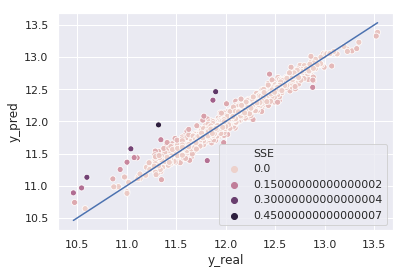

Submission head:


Id      SalePrice
0  1461  128239.890002
1  1462  154568.297709
2  1463  183769.677697
3  1464  198894.468466
4  1465  197256.160519

Submission created in: complex_stack_lasso_ls_True_False.csv
lasso_ls_True_True
RMSE train:  0.08503844331180023  +- 0.02660606741513573
RMSE test:  0.11256592654108519  +- 0.031238463545676824
Full RMSE train: 0.08562325709768363
Real x Predicted


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


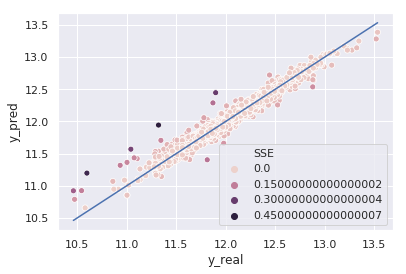

Submission head:


Id      SalePrice
0  1461  127177.740673
1  1462  157382.648557
2  1463  183358.087336
3  1464  197341.405271
4  1465  194946.504717

Submission created in: complex_stack_lasso_ls_True_True.csv
lasso_ls_False_False
RMSE train:  0.08355812801249339  +- 0.019918771785639274
RMSE test:  0.11165708734300489  +- 0.03164100678335437
Full RMSE train: 0.08736500911902695
Real x Predicted


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


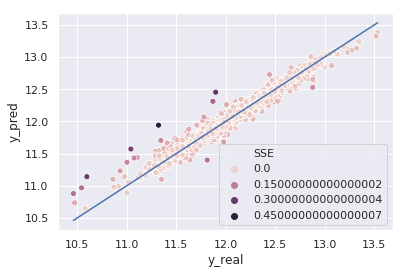

Submission head:


Id      SalePrice
0  1461  128118.509326
1  1462  154814.339701
2  1463  182977.423970
3  1464  195916.350659
4  1465  195243.552594

Submission created in: complex_stack_lasso_ls_False_False.csv
lasso_ls_False_True
RMSE train:  0.08326854116025238  +- 0.025094180211475817
RMSE test:  0.11256253315833027  +- 0.03197470029924425
Full RMSE train: 0.08461280065041255
Real x Predicted


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


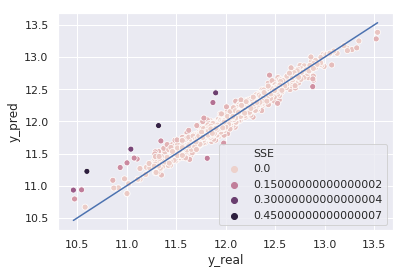

Submission head:


Id      SalePrice
0  1461  127020.670456
1  1462  157564.545715
2  1463  182926.971376
3  1464  195360.342423
4  1465  193513.153276

Submission created in: complex_stack_lasso_ls_False_True.csv
CPU times: user 1h 12min 5s, sys: 1min 3s, total: 1h 13min 8s
Wall time: 1h 11min 54s


In [60]:
%%time

meta_models = [#(RandomForestRegressor(max_depth=4, n_estimators=100, random_state=42), 'rf'), 
               #(SVR(kernel='rbf', gamma = 'scale', C = 1.0, shrinking=True), 'svm'),
               (Lasso(alpha=0.001, max_iter=1000, random_state=42),'lasso')
              ]

complex_models = dict()

for loss_gb, is_lm, remove_unimportant, meta_model in product(['huber', 'ls'], [True, False], [False,True], meta_models):
    
    meta_model, name = meta_model
    
    name = '{}_{}_{}_{}'.format(name, loss_gb, is_lm, remove_unimportant)
    print('='*60)
    print(name)
    
    # preprocs
    fitted_transformer = lm_t if is_lm else my_t
    
    preproc_transformer = FunctionTransformer(func=preproc, validate=False, kw_args={'is_lm' : is_lm, 'fitted_transf' : fitted_transformer, 'remove_unimportant' : remove_unimportant})
    #preproc_lm = lambda df : preproc(df, fitted_transf=lm_t, is_lm=True)
    preproc_transformer_lm = FunctionTransformer(func=preproc, validate=False, kw_args={'is_lm' : True, 'fitted_transf' : lm_t, 'remove_unimportant' : remove_unimportant})
    
    # gb
    gb_basic = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.001, loss = loss_gb, max_depth=4,
             max_features=20, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=3, min_samples_split=8,
             min_weight_fraction_leaf=0.0, n_estimators=18000,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=0.1, tol=0.0001, validation_fraction=0.2, verbose=0,
             warm_start=False)

    gb_pipe = Pipeline([('preproc', preproc_transformer), ('gb', gb_basic)])
    
    # xgb
    xgb_basic = XGBRegressor(max_depth=4, learning_rate=0.01, n_estimators=2000, silent=True, objective='reg:linear', booster='gbtree',
                         n_jobs=1, nthread=None, gamma=0, min_child_weight=3, max_delta_step=0, subsample=0.3, colsample_bytree=0.7, 
                         colsample_bylevel=1, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, base_score=0.5, 
                         random_state=42, missing=None)


    xgb_pipe = Pipeline([('preproc', preproc_transformer),('xgb', xgb_basic)])

    
    # svr
    svr = SVR(kernel='rbf', gamma = 0.001, C = 6.0, shrinking=True)
    svr_pipe = Pipeline([('preproc', preproc_transformer_lm),('scaler', RobustScaler()) , ('svm', svr)]) 
    
    # lasso
    lasso = Lasso(alpha = 0.0009, max_iter=11000, tol= 1e-4, random_state=42) #LassoCV(normalize=True, max_iter=1000, random_state=42, n_alphas=5000, cv = kfold)
    lasso_pipe = Pipeline([('preproc', preproc_transformer_lm),('scaler', RobustScaler()), ('lasso', lasso)])

    
    my_complex_stack = complex_stack(models=[gb_pipe, xgb_pipe, lasso_pipe, svr_pipe], meta_model=meta_model)
    evaluate_model(my_complex_stack, df_train, y_train, cv = 2)
    complex_models[name] = my_complex_stack
    
    create_submission('complex_stack_{}'.format(name), 'SalePrice', df_test, my_complex_stack, lambda x : x)


- With Lasso(alpha=0.001, max_iter=10000, random_state=42)
- With drop
- With KB 5

LB 0.11747

-------------
# TMP

------------------------
## Where is the model going wrong

create_error_df(df, df_basic, y, gb_basic, 'gb_basic')

-------------------------
## Randomized Grid Search

%%time
do_rscv = True
n_iter = 60*5

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

rmse_score = make_scorer(lambda y_true,y_pred : mean_squared_error(y_true,y_pred)**0.5, greater_is_better=False)
params_dic = {
    'loss' : ['huber', 'ls'],
    'learning_rate': [0.1,0.05,0.01,0.001],
    'n_estimators' : [1000, 5000, 10000],
    'subsample' : [0.3,0.4,0.5],
    'criterion' : ['friedman_mse'],
    'min_samples_split' : [2,5,8,10,15], 
    'min_samples_leaf' : [1,3,4,5,8,10,12,15],
    'min_weight_fraction_leaf' : [0.0],
    'max_depth' : [3,4,5,8,10,20],
    'min_impurity_decrease' : [0.0,0.1,0.2],
    'min_impurity_split' : [None], 
    'random_state' : [42],
    'max_features' : [5,8,10,12,15,20,None], 
    'alpha' : [0.01, 0.1, 0.5, 0.9], 
    'max_leaf_nodes' : [None], 
    'presort' : ['auto'], 
    'validation_fraction' : [0.2], 
    'n_iter_no_change' : [None]
}

if do_rscv:
    #CPU times: user 1h 35min 10s, sys: 1.06 s, total: 1h 35min 11s
    gb_rs = GradientBoostingRegressor()
    rscv = RandomizedSearchCV(gb_rs, params_dic, n_iter = n_iter, scoring=rmse_score, cv = kfold, return_train_score=True, random_state=42)
    rscv.fit(df_basic, y)
    rscv_results = pd.DataFrame(data = rscv.cv_results_).sort_values('rank_test_score')
    rscv_results['mean_test_half_std'] = rscv_results.mean_test_score - 0.5*rscv_results.std_test_score
    rscv_results.to_pickle('gb_rscv_results.p')    
    display(rscv_results.head())
    print(rscv.best_estimator_)
    gb_rscv = rscv.best_estimator_
    gb_rscv = evaluate_model(gb_rscv, df_basic, y, cv = 5)
else:
    pass
    #rscv_results = pd.read_pickle('gb_rscv_results.p')

create_error_df(df, df_basic, y, gb_rscv, 'gb_rscv')

datetime_str = datetime.datetime.now().strftime('%D %T').replace('/','-')

#mean_test_score order
display(rscv_results[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'mean_test_half_std']].head())
#mean_test_half_std order
display(rscv_results[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'mean_test_half_std']].sort_values('mean_test_half_std',
                                                                                                                                     ascending = False).head())
for idx, value in rscv_results.mean_test_half_std.sort_values(ascending = False).head().iteritems():
    gb_tmp = GradientBoostingRegressor()
    gb_tmp.set_params(**rscv_results.loc[idx,'params'])
    
    print('Evaluating the model:',idx)
    print(gb_tmp)    
    gb_tmp = evaluate_model(gb_tmp, df_basic, y, cv = 5);
    
    print('Creating submission:')
    model_name = 'gb_rscv_id{}_{}'.format(idx,datetime_str)
    create_submission(model_name, target_col, df_test, gb_tmp, tranf_func = preproc)
